<a href="https://colab.research.google.com/github/PyMap/MDG/blob/master/Clase%204/04_03_Ecobici_NetworkX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Grafos y redes de transporte

# Clase 4

##  Parte 2. Teoría de grafos con `NetworkX` 
### Aplicando conceptos sobre un sistema de transporte

#### La red EcoBici en la Ciudad de Buenos Aires

Como cualquier sistema de transporte, la red de bicicletas puede entenderse como una estructura sencilla de nodos conectados por ejes o arcos. 

Ahora bien, la forma en la que se estructure dicha red puede variar dependiendo del modo en el que dispongamos sus componentes principales. En nuestro caso, ciclistas, estaciones, ciclovías, recorridos, etc. 

Por eso, a la hora de utilizar un grafo para representar una red de transporte debemos considerar dos cuestiones esenciales:

1. ¿Cuáles serán los nodos y cuáles los ejes que los conecten?
2. ¿Cuál será el sentido de las conexiones entre nodos y qué tipo de grafo utilizaremos para representarlas?  

Una vez resueltas estas definiciones, también será importante tener en cuenta con qué información contamos para caracterizar los nodos y ejes de nuestra red. Esto puede hacernos volver atrás en algunas de nuestras decisiones previas, por eso, la disponibilidad de información no es algo menor. De ello dependerá, por ejemplo, la manera en la que ponderemos (o no) las relaciones entre vértices.

Normalmente, en una red de transporte los nodos se encuentran representados por las estaciones. Por su parte, los ejes pueden tomar la forma de las vías que los conectan - ya sean las calles o carriles que delimitan el recorrido en cuestión -, o incluso, los viajes realizados entre nodos.

En este último caso, los atributos serán diferentes. Un viaje realizado puede caracterizarse por la edad del individuo que se moviliza mientras que el tramo del recorrido puede tener un largo en distancia.

![caption](../imagenes/estructura_red.png)

#### Definiciones operativas

Vamos a considerar a la red pública de bicicletas como una estructura donde las estaciones son las unidades de procesamiento de información (o nodos) y las rutas transitadas que los vinculan, la conexión (o arco). Así, nuestra red estará constituida por un conjunto de estaciones (identificadas en nuestro dataframe por un nombre o un "identifier") conectadas por los viajes realizados entre los dos extremos (origen y destino). Con relación a esto último, es importante aclarar que cada viaje tendrá un sentido o direccionalidad - "direction")  

<u>Componentes principales</u>:

    1) NODOS: Estaciones
    2) CONEXION (edge): Viajes o Recorridos (necesidad de desplazamiento)
    
<u>Comportamiento de la red</u>:

    3) DIRECCIONALIDAD: 
       3.1. Sentido del viaje: origen-destino (distintas estaciones + self-loops)
    
<u>Atributos de la red</u>:

    4) PESOS (intensidad de la conexion): 
       4.1.Distancia medida en tiempo de uso
       4.2.Cantidad de recorridos realizados entre estaciones

In [8]:
# librerias (manipulacion de datos y georreferenciacion) 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import plotly_express as px
import seaborn as sns

In [13]:
# Cargamos datasets de recorridos
df = {}
for i in range(15,20):
    path = 'https://storage.googleapis.com/python_mdg/data_cursos/bici{}_cdn.csv'.format(str(i))
    df[str(i)] = pd.read_csv(path)

In [27]:
df['15'].head()

bici_id_usuario bici_Fecha_hora_retiro  bici_tiempo_uso  \
0         134224.0    2015-12-31 20:30:05             14.0   
1         134224.0    2015-12-31 19:58:37             25.0   
2         222555.0    2015-12-31 18:42:54             57.0   
3          11504.0    2015-12-31 17:55:29             15.0   
4         183241.0    2015-12-31 16:59:29             24.0   

  bici_nombre_estacion_origen  bici_estacion_origen  \
0                      Aduana                     3   
1                      Retiro                     2   
2                    Congreso                     8   
3               Plaza Almagro                    17   
4               Plaza Almagro                    17   

  bici_nombre_estacion_destino  bici_estacion_destino  bici_sexo  bici_edad  
0                   Tribunales                   11.0  MASCULINO       71.0  
1                       Aduana                    3.0  MASCULINO       71.0  
2                       Retiro                    2.0  MASCULINO       26.0  
3                     Congreso                    8.0  MASCULINO       26.0  
4                Plaza Almagro                   17.0   FEMENINO       59.0

In [31]:
from shapely import wkt

In [32]:
# Shape de estaciones descargados de DataBA
estaciones_wkt = pd.read_csv('https://storage.googleapis.com/python_mdg/carto_cursos/estaciones_ecobici.csv', index_col=[0])
proj = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'

In [33]:
# load geom from wkt
def from_wkt(df, wkt_column, crs=4326):
    
    df["geometry"]= df[wkt_column].apply(wkt.loads) 
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs=crs) 
    
    return gdf

In [34]:
estaciones = from_wkt(estaciones_wkt, 'str_geom').to_crs(proj)

<AxesSubplot:>

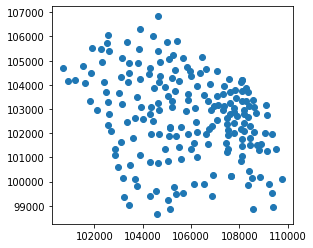

In [35]:
estaciones.plot()

<u> **Comportamiento de la red** </u>

Debemos tener en cuenta que el sistema público de bicicletas fue diseñado para funcionar sobre una red de ciclovías. Esto significa que el sentido (u orden) del recorrido importa. Se puede ir de una estación a otra o biceversa, como así también, salir y llegar a la misma estación (selfloop) 

Todas las ciclovías tienen una dirección de ida y otra de vuelta. No hay casos en los que haya un sentido y casos donde haya otro, como puede suceder con las calles. Entonces, todos los caminos son bidireccionales.

Por lo tanto, si el orden importa, ¿es nuestra red un grafo dirigido o no dirigido?

![caption](../imagenes/dirigido_nodirigido.png)

Como vemos en la ilustración, en un grafo dirigido sólo hay un arco entre (por ejemplo) A y B. Se puede ir de A a B pero no de B a A. Suponiendo que estas fuesen nuestras estaciones, la forma que adoptarían en un grafo dirigido sería A -> B. 

Ahora bien, como dijimos anteriormente, un ciclista puede ir de A a B o de B a A dependiendo hacia a dónde necesite desplazarse. Es decir que, en nuestro grafo las estaciones no deberían tener direccionalidad porque se pueden conectar en ambos sentidos. Con lo cual, si lo ponemos en términos de un grafo no dirigido, las estaciones tomarían la forma A - B. Se puede ir de A a B y de B a A.

Probemos entonces de esta manera...

In [6]:
# Se crea una funcion para generar el grafo de la red de transporte donde el nodo es la estacion y el arco el viaje o recorrido
def graphmaker(df, origen, destino):
    '''
    Devuelve un grafo compuesto por estaciones(nodos) y recorridos(vinculos) para cada dataframe.
    ...
    Argumentos:
    
    df = dataframe de recorridos
    origen = Serie del dataframe referenciando la estacion de origen del grafo
    destino = Serie del dataframe referenciando la estacion de destino del grafo
    '''
    # se usa size() y no count() por si hubiera null cases
    agrupado = df.groupby([origen,destino]).size().reset_index(name='recorridos')
    agrupado.columns = ['origen','destino','recorridos']
    # crea un grafo tomando el df con groupby que registra todas las posibles combinaciones de estaciones y su frecuencia
    bicigrafo = nx.from_pandas_edgelist(agrupado,'origen','destino','recorridos')
    return bicigrafo

In [7]:
# Probemos la funcion para crear un grafo a partir de un dataframe elegido arbitrariamente
b18 = graphmaker(df18,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

NameError: name 'nx' is not defined

In [8]:
# Ahora veamos qué nos devuelve
print(type(b18))

<class 'networkx.classes.graph.Graph'>


In [9]:
print("Se crea un Grafo de %r nodos con %r arcos" % (len(b18.nodes()), len(b18.edges())) )

Se crea un Grafo de 199 nodos con 19575 arcos


Siguiendo esta lógica, obtenemos un grafo de alrededor de 200 nodos con un poco menos de 20.000 arcos. ¿Cómo podemos revisar si esto está bien? Primero veamos cuántas combinaciones posibles hay entre el universo de estaciones con un groupby.

In [10]:
agrupado = df18.groupby(['bici_nombre_estacion_origen','bici_nombre_estacion_destino']).size().reset_index(name='recorridos')

In [11]:
# Vemos que las estaciones de bicicleta se pueden combinar de 38334 maneras posibles. Recordemos que el groupby toma una
# estacion y la contrasta contra todas las restantes computando la cantidad de casos que hay para cada par (origen-destino)
len(agrupado)

38334

Esto significa que si construimos nuestra red como si fuese un "grafo no dirigido" estaríamos perdiendo vínculos entre nodos. ¿Cómo se puede explicar eso? 

Como dijimos anteriormente, en esta familia de grafos no importa el orden porque los nodos pueden conectarse en ambas direcciones o sentidos. Esto hace que la cantidad máxima de ejes entre nodos se piense como una combinación de "n" elementos tomados de "k" en "k". 

![caption](../imagenes/formulas.png)

Sin embargo, nuestro problema responde más bien a una permutación que a una combinación. Como se mencionó anteriormente, el orden de las conexiones importa porque ir de A a B o de B a A no es lo mismo para nosotros. Es por esto que no deberíamos utilizar en el denominador k!. Cada par de estaciones es único para nosotros. Así, suponiendo que tenemos 200 nodos, ¿cuál sería la cantidad máxima de arcos (edges) en un grafo dirigido o otro no dirigido? 

In [12]:
# Primero armamos una funcion para devolver el factorial de un nro.

def factorial (*n):
    for x in n:
        fac=1
    for y in range(1,x+1):
        fac=fac*y
    return fac 

In [13]:
# En un grafo no dirigido: no se tiene en cuenta el orden. A-B | B-A es lo mismo (divide por 2!)
Lmax = factorial(200)/((factorial(200-2))*(factorial(2)))
Lmax

19900.0

Veamos cómo en un grafo no dirigido el orden no importa. Para ello tomamos el grafo de 2018 y tomamos un par de estaciones al azar. En este ejemplo se puede empezar desde 25 de Mayo o 15 de Noviembre y terminar en cualquiera de las dos estaciones. Para nosotros, ir de una a otra no es lo mismo que ir en sentido contrario. El orden sí importa (sentido o dirección del recorrido).

In [14]:
# Cuenta los self loops pero no respeta el orden. 
a = pd.DataFrame(b18.edges(data=True))
a.columns = ['origen','destino','recorridos']
a.loc[((a['origen']=='15 de Noviembre') | (a['origen']=='25 de Mayo')) &
      ((a['destino']=='15 de Noviembre') | (a['destino']=='25 de Mayo'))]

origen          destino            recorridos
0    15 de Noviembre  15 de Noviembre   {'recorridos': 494}
1    15 de Noviembre       25 de Mayo     {'recorridos': 7}
196       25 de Mayo       25 de Mayo  {'recorridos': 1246}

Como se puede observar, en el grafo no se computó el par (25 de Mayo - 15 de Noviembre) pero sí (15 de Noviembre - 25 de Mayo). Esto quiere decir que, al momento de armar el grafo se debe haber considerado solamente el par de estaciones que estaba indexado primero en el dataframe que se pasó como input dentro del "nx.from_pandas_edgelist()" que usamos en la función. Esto mismo se puede comprobrar en otros pares de estaciones! 

In [15]:
# Vemos que ese recorrido no existe
a.loc[(a['origen']=='25 de Mayo') & (a['destino']=='15 de Noviembre')]

Empty DataFrame
Columns: [origen, destino, recorridos]
Index: []

In [16]:
# Constatamos que el recorrido (25 de Mayo - 15 de Noviembre existe). Tambien que las frecuencias estan cruzadas (7 y no 2)
agrupado.columns = ['origen','destino','recorridos']

agrupado.loc[((agrupado['origen']=='15 de Noviembre') | (agrupado['origen']=='25 de Mayo')) & 
             ((agrupado['destino']=='15 de Noviembre') | (agrupado['destino']=='25 de Mayo'))]

origen          destino  recorridos
0    15 de Noviembre  15 de Noviembre         494
1    15 de Noviembre       25 de Mayo           2
190       25 de Mayo  15 de Noviembre           7
191       25 de Mayo       25 de Mayo        1246

En esta tabla también se puede ver que las conexiones más fuertes se dan para los self-loops y no para las recíprocas (A->B, B->A)

In [17]:
# En un grafo dirigido: se tiene en cuenta el orden. A-B | B-A no es lo mismo (no divide por 2!)
Lmax = factorial(200)/factorial(198)
Lmax

39800.0

Como se puede observar, en un grafo no dirigido la cantidad de ejes se asemeja mucho más al total de pares únicos que habíamos encontrado aplicando un groupby sobre el dataframe de recorridos inicial. Esto es porque en un grafo dirigido el orden de la conexión sí importa. 

Por lo tanto, para reconstruir la red de ecobicis vamos a trabajar con un grafo dirigido como si este no lo fuera. Es decir que, simularemos un grafo no dirigido a partir de otro dirigido que se construya con los pares de arcos que existen en ambas direcciones (A->B y B->A). A continuación, vemos los movimientos posibles en nuestra red de bicicletas. Esto es, yendo de una estación a otra o biceversa y saliendo/llegando a la misma estación.  

![caption](../imagenes/movimientos.png)

In [18]:
# Rearmamos la funcion anterior para que el grafo sea dirigido
def graphmaker(df, origen, destino):
    '''
    Devuelve un grafo compuesto por estaciones(nodos) y recorridos(vinculos) para cada dataframe.
    ...
    Argumentos:
    
    df = dataframe de recorridos
    origen = Serie del dataframe referenciando la estacion de origen del grafo
    destino = Serie del dataframe referenciando la estacion de destino del grafo
    '''
    D = nx.DiGraph()
    
    # se usa size() y no count() por si hubiera null cases
    agrupado = df.groupby([origen,destino]).size().reset_index(name='recorridos')
    agrupado.columns = ['origen','destino','recorridos']
    
    vinculados = zip(agrupado['origen'],agrupado['destino'])
    
    D.add_edges_from(vinculados)
    
    # Setear atributos de los ejes: se pasa un diccionario de diccionario donde la key son los nodos de cada eje
    
    # Key 
    k=list(zip(agrupado['origen'],agrupado['destino']))
    
    # Values: para cada eje sus atributos se computan como un diccionario con k(nombre del atributo) y v(valor del atributo)
    
    # Atributo 1: cantidad de recorridos para cada eje (o camino constitudo por el par de nodos)
    recorridos = agrupado['recorridos']
    
    # Atributo 2: tiempo promedio en el que se recorre el eje (recordar que el eje es el camino unido entre nodos)
    tiempo = round(df18.groupby(['bici_nombre_estacion_origen','bici_nombre_estacion_destino'])[['bici_tiempo_uso']].mean().reset_index()['bici_tiempo_uso'],0)
    
    # Atributo 3: edad promedio de los usuarios que recorrieron cada eje
    edad = round(df18.groupby(['bici_nombre_estacion_origen','bici_nombre_estacion_destino'])[['bici_edad']].mean().reset_index()['bici_edad'],1)
    
    # Creamos el diccionario de atributos 
    sub_dict = [{'recorridos':i[0],'tiempo':i[1], 'edad':i[2]} for i in list(zip(recorridos,tiempo,edad))]
    
    # Zipeamos un diccionario de atributos para cada diccionario en el que la key es el par de extremos del eje
    atributos = dict(zip(k,sub_dict))
    
    # Actualizamos los atributos del grafo
    nx.set_edge_attributes(D, atributos)
    
    return D

In [19]:
# Testeamos la funcion
grafo_test = graphmaker(df18,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

In [20]:
# Nos crea un grafo de 199 nodos y 38334 ejes
len(grafo_test.nodes()), len(grafo_test.edges())

(199, 38334)

Concibiéndolo como dirigido, creamos un grafo mucho más acorde al comportamiento real de la red. Ahora se respeta la manera como están ordenadas las estaciones. Para nosotros es importante porque esto nos define el sentido de cada viaje que es lo que estamos usando como eje entre nodos. Ahora revisamos los atributos que seteamos en la funcion para los ejes:

In [21]:
# Tiempo promedio en el que los usuarios recorrieron el eje (tomamos un par de nodos al azar)
grafo_test['15 de Noviembre']['15 de Noviembre']['tiempo']

52.0

In [22]:
# Cantidad de recorridos para cada eje (o par de nodos)
grafo_test['15 de Noviembre']['15 de Noviembre']['recorridos']

494

In [23]:
# Edad promedio de los usuarios que recorrieron cada eje
grafo_test['15 de Noviembre']['15 de Noviembre']['edad']

34.8

In [24]:
# Iteramos sobre la metadata de todos los ejes y podemos ver todos los atributos
for u,v,d in grafo_test.edges(data=True):
     print(d)

{'recorridos': 494, 'tiempo': 52.0, 'edad': 34.8}
{'recorridos': 2, 'tiempo': 43.0, 'edad': 45.0}
{'recorridos': 7, 'tiempo': 34.0, 'edad': 34.1}
{'recorridos': 26, 'tiempo': 83.0, 'edad': 35.7}
{'recorridos': 10, 'tiempo': 35.0, 'edad': 30.6}
{'recorridos': 10, 'tiempo': 39.0, 'edad': 31.2}
{'recorridos': 3, 'tiempo': 80.0, 'edad': 25.3}
{'recorridos': 12, 'tiempo': 36.0, 'edad': 35.5}
{'recorridos': 13, 'tiempo': 28.0, 'edad': 26.8}
{'recorridos': 1, 'tiempo': 30.0, 'edad': 23.0}
{'recorridos': 6, 'tiempo': 48.0, 'edad': 25.5}
{'recorridos': 2, 'tiempo': 31.0, 'edad': 27.0}
{'recorridos': 10, 'tiempo': 35.0, 'edad': 32.9}
{'recorridos': 3, 'tiempo': 44.0, 'edad': 27.0}
{'recorridos': 12, 'tiempo': 139.0, 'edad': 32.7}
{'recorridos': 29, 'tiempo': 26.0, 'edad': 36.4}
{'recorridos': 29, 'tiempo': 18.0, 'edad': 26.7}
{'recorridos': 33, 'tiempo': 23.0, 'edad': 30.9}
{'recorridos': 7, 'tiempo': 25.0, 'edad': 30.1}
{'recorridos': 9, 'tiempo': 68.0, 'edad': 27.6}
{'recorridos': 4, 'tiempo':

{'recorridos': 82, 'tiempo': 31.0, 'edad': 30.4}
{'recorridos': 345, 'tiempo': 25.0, 'edad': 28.8}
{'recorridos': 92, 'tiempo': 24.0, 'edad': 32.3}
{'recorridos': 8, 'tiempo': 55.0, 'edad': 38.8}
{'recorridos': 294, 'tiempo': 19.0, 'edad': 31.8}
{'recorridos': 13, 'tiempo': 43.0, 'edad': 32.5}
{'recorridos': 118, 'tiempo': 49.0, 'edad': 31.1}
{'recorridos': 40, 'tiempo': 23.0, 'edad': 31.3}
{'recorridos': 205, 'tiempo': 30.0, 'edad': 31.2}
{'recorridos': 36, 'tiempo': 42.0, 'edad': 34.3}
{'recorridos': 29, 'tiempo': 34.0, 'edad': 29.4}
{'recorridos': 36, 'tiempo': 29.0, 'edad': 29.9}
{'recorridos': 11, 'tiempo': 29.0, 'edad': 30.5}
{'recorridos': 88, 'tiempo': 26.0, 'edad': 34.9}
{'recorridos': 174, 'tiempo': 30.0, 'edad': 35.5}
{'recorridos': 321, 'tiempo': 31.0, 'edad': 32.4}
{'recorridos': 44, 'tiempo': 27.0, 'edad': 31.1}
{'recorridos': 210, 'tiempo': 26.0, 'edad': 35.0}
{'recorridos': 87, 'tiempo': 39.0, 'edad': 33.1}
{'recorridos': 1069, 'tiempo': 29.0, 'edad': 31.1}
{'recorridos

{'recorridos': 8, 'tiempo': 36.0, 'edad': 29.0}
{'recorridos': 280, 'tiempo': 26.0, 'edad': 32.2}
{'recorridos': 11, 'tiempo': 29.0, 'edad': 35.4}
{'recorridos': 3, 'tiempo': 41.0, 'edad': 34.7}
{'recorridos': 16, 'tiempo': 26.0, 'edad': 34.9}
{'recorridos': 31, 'tiempo': 28.0, 'edad': 38.1}
{'recorridos': 78, 'tiempo': 18.0, 'edad': 32.2}
{'recorridos': 33, 'tiempo': 33.0, 'edad': 24.2}
{'recorridos': 42, 'tiempo': 35.0, 'edad': 33.8}
{'recorridos': 3, 'tiempo': 113.0, 'edad': 25.7}
{'recorridos': 14, 'tiempo': 39.0, 'edad': 32.8}
{'recorridos': 89, 'tiempo': 18.0, 'edad': 28.0}
{'recorridos': 27, 'tiempo': 23.0, 'edad': 31.3}
{'recorridos': 6, 'tiempo': 29.0, 'edad': 26.0}
{'recorridos': 16, 'tiempo': 28.0, 'edad': 33.2}
{'recorridos': 15, 'tiempo': 60.0, 'edad': 35.6}
{'recorridos': 25, 'tiempo': 56.0, 'edad': 29.5}
{'recorridos': 10, 'tiempo': 27.0, 'edad': 31.9}
{'recorridos': 110, 'tiempo': 11.0, 'edad': 36.0}
{'recorridos': 24, 'tiempo': 24.0, 'edad': 33.3}
{'recorridos': 55, 't

{'recorridos': 9, 'tiempo': 37.0, 'edad': 39.0}
{'recorridos': 21, 'tiempo': 36.0, 'edad': 45.6}
{'recorridos': 22, 'tiempo': 30.0, 'edad': 36.5}
{'recorridos': 23, 'tiempo': 32.0, 'edad': 40.9}
{'recorridos': 48, 'tiempo': 21.0, 'edad': 35.3}
{'recorridos': 6, 'tiempo': 52.0, 'edad': 36.0}
{'recorridos': 12, 'tiempo': 31.0, 'edad': 30.6}
{'recorridos': 15, 'tiempo': 33.0, 'edad': 37.2}
{'recorridos': 7, 'tiempo': 27.0, 'edad': 22.1}
{'recorridos': 19, 'tiempo': 41.0, 'edad': 36.8}
{'recorridos': 116, 'tiempo': 18.0, 'edad': 38.7}
{'recorridos': 23, 'tiempo': 23.0, 'edad': 28.3}
{'recorridos': 2, 'tiempo': 45.0, 'edad': 25.0}
{'recorridos': 51, 'tiempo': 26.0, 'edad': 32.0}
{'recorridos': 129, 'tiempo': 26.0, 'edad': 36.6}
{'recorridos': 124, 'tiempo': 28.0, 'edad': 39.3}
{'recorridos': 101, 'tiempo': 18.0, 'edad': 44.6}
{'recorridos': 42, 'tiempo': 21.0, 'edad': 33.4}
{'recorridos': 15, 'tiempo': 41.0, 'edad': 40.5}
{'recorridos': 36, 'tiempo': 31.0, 'edad': 34.2}
{'recorridos': 17, '

{'recorridos': 10, 'tiempo': 163.0, 'edad': 33.1}
{'recorridos': 19, 'tiempo': 37.0, 'edad': 34.6}
{'recorridos': 43, 'tiempo': 33.0, 'edad': 40.1}
{'recorridos': 136, 'tiempo': 28.0, 'edad': 30.3}
{'recorridos': 248, 'tiempo': 21.0, 'edad': 33.9}
{'recorridos': 11, 'tiempo': 39.0, 'edad': 38.6}
{'recorridos': 195, 'tiempo': 44.0, 'edad': 30.9}
{'recorridos': 138, 'tiempo': 28.0, 'edad': 28.9}
{'recorridos': 85, 'tiempo': 17.0, 'edad': 28.8}
{'recorridos': 84, 'tiempo': 17.0, 'edad': 38.0}
{'recorridos': 6, 'tiempo': 43.0, 'edad': 35.8}
{'recorridos': 20, 'tiempo': 34.0, 'edad': 30.0}
{'recorridos': 80, 'tiempo': 25.0, 'edad': 37.2}
{'recorridos': 95, 'tiempo': 15.0, 'edad': 35.6}
{'recorridos': 69, 'tiempo': 28.0, 'edad': 31.7}
{'recorridos': 127, 'tiempo': 24.0, 'edad': 32.3}
{'recorridos': 20, 'tiempo': 61.0, 'edad': 35.0}
{'recorridos': 48, 'tiempo': 27.0, 'edad': 33.1}
{'recorridos': 159, 'tiempo': 29.0, 'edad': 36.9}
{'recorridos': 135, 'tiempo': 22.0, 'edad': 34.8}
{'recorridos'

{'recorridos': 9, 'tiempo': 46.0, 'edad': 37.4}
{'recorridos': 191, 'tiempo': 28.0, 'edad': 32.3}
{'recorridos': 35, 'tiempo': 35.0, 'edad': 31.1}
{'recorridos': 24, 'tiempo': 60.0, 'edad': 33.2}
{'recorridos': 74, 'tiempo': 37.0, 'edad': 44.9}
{'recorridos': 199, 'tiempo': 35.0, 'edad': 33.8}
{'recorridos': 96, 'tiempo': 42.0, 'edad': 34.2}
{'recorridos': 381, 'tiempo': 28.0, 'edad': 33.0}
{'recorridos': 3, 'tiempo': 36.0, 'edad': 18.7}
{'recorridos': 29, 'tiempo': 20.0, 'edad': 25.8}
{'recorridos': 1, 'tiempo': 44.0, 'edad': 30.0}
{'recorridos': 27, 'tiempo': 36.0, 'edad': 28.4}
{'recorridos': 67, 'tiempo': 18.0, 'edad': 28.6}
{'recorridos': 2, 'tiempo': 38.0, 'edad': 25.5}
{'recorridos': 522, 'tiempo': 13.0, 'edad': 28.9}
{'recorridos': 4, 'tiempo': 50.0, 'edad': 33.2}
{'recorridos': 13, 'tiempo': 29.0, 'edad': 36.5}
{'recorridos': 35, 'tiempo': 70.0, 'edad': 27.4}
{'recorridos': 56, 'tiempo': 21.0, 'edad': 30.1}
{'recorridos': 112, 'tiempo': 16.0, 'edad': 31.0}
{'recorridos': 570, 

{'recorridos': 1, 'tiempo': 31.0, 'edad': 26.0}
{'recorridos': 3, 'tiempo': 37.0, 'edad': 34.0}
{'recorridos': 19, 'tiempo': 20.0, 'edad': 38.4}
{'recorridos': 8, 'tiempo': 56.0, 'edad': 36.1}
{'recorridos': 23, 'tiempo': 33.0, 'edad': 34.7}
{'recorridos': 57, 'tiempo': 38.0, 'edad': 36.3}
{'recorridos': 26, 'tiempo': 79.0, 'edad': 52.5}
{'recorridos': 35, 'tiempo': 14.0, 'edad': 33.3}
{'recorridos': 13, 'tiempo': 49.0, 'edad': 31.1}
{'recorridos': 107, 'tiempo': 36.0, 'edad': 36.0}
{'recorridos': 50, 'tiempo': 25.0, 'edad': 37.5}
{'recorridos': 1, 'tiempo': 78.0, 'edad': 29.0}
{'recorridos': 5, 'tiempo': 51.0, 'edad': 31.8}
{'recorridos': 17, 'tiempo': 28.0, 'edad': 36.9}
{'recorridos': 60, 'tiempo': 20.0, 'edad': 35.5}
{'recorridos': 2, 'tiempo': 52.0, 'edad': 24.5}
{'recorridos': 7, 'tiempo': 37.0, 'edad': 34.7}
{'recorridos': 174, 'tiempo': 10.0, 'edad': 39.8}
{'recorridos': 129, 'tiempo': 27.0, 'edad': 29.5}
{'recorridos': 57, 'tiempo': 38.0, 'edad': 33.6}
{'recorridos': 7, 'tiemp

{'recorridos': 48, 'tiempo': 33.0, 'edad': 35.6}
{'recorridos': 26, 'tiempo': 46.0, 'edad': 31.6}
{'recorridos': 62, 'tiempo': 57.0, 'edad': 33.7}
{'recorridos': 96, 'tiempo': 23.0, 'edad': 30.3}
{'recorridos': 151, 'tiempo': 33.0, 'edad': 40.2}
{'recorridos': 39, 'tiempo': 33.0, 'edad': 30.8}
{'recorridos': 5, 'tiempo': 54.0, 'edad': 32.0}
{'recorridos': 21, 'tiempo': 41.0, 'edad': 33.0}
{'recorridos': 49, 'tiempo': 50.0, 'edad': 30.8}
{'recorridos': 224, 'tiempo': 26.0, 'edad': 35.8}
{'recorridos': 1, 'tiempo': 50.0, 'edad': 25.0}
{'recorridos': 8, 'tiempo': 46.0, 'edad': 33.2}
{'recorridos': 35, 'tiempo': 39.0, 'edad': 32.7}
{'recorridos': 163, 'tiempo': 29.0, 'edad': 34.1}
{'recorridos': 87, 'tiempo': 25.0, 'edad': 34.5}
{'recorridos': 12, 'tiempo': 33.0, 'edad': 29.2}
{'recorridos': 58, 'tiempo': 36.0, 'edad': 35.5}
{'recorridos': 2, 'tiempo': 42.0, 'edad': 38.0}
{'recorridos': 100, 'tiempo': 54.0, 'edad': 32.4}
{'recorridos': 51, 'tiempo': 25.0, 'edad': 39.9}
{'recorridos': 21, '

{'recorridos': 31, 'tiempo': 29.0, 'edad': 29.7}
{'recorridos': 40, 'tiempo': 53.0, 'edad': 35.8}
{'recorridos': 44, 'tiempo': 42.0, 'edad': 34.2}
{'recorridos': 35, 'tiempo': 17.0, 'edad': 34.2}
{'recorridos': 110, 'tiempo': 15.0, 'edad': 33.6}
{'recorridos': 77, 'tiempo': 27.0, 'edad': 31.7}
{'recorridos': 98, 'tiempo': 20.0, 'edad': 33.8}
{'recorridos': 143, 'tiempo': 24.0, 'edad': 34.4}
{'recorridos': 14, 'tiempo': 34.0, 'edad': 37.0}
{'recorridos': 101, 'tiempo': 12.0, 'edad': 38.0}
{'recorridos': 13, 'tiempo': 28.0, 'edad': 29.5}
{'recorridos': 25, 'tiempo': 16.0, 'edad': 29.3}
{'recorridos': 29, 'tiempo': 17.0, 'edad': 42.7}
{'recorridos': 69, 'tiempo': 37.0, 'edad': 34.2}
{'recorridos': 5, 'tiempo': 46.0, 'edad': 42.0}
{'recorridos': 9, 'tiempo': 34.0, 'edad': 36.0}
{'recorridos': 25, 'tiempo': 24.0, 'edad': 33.6}
{'recorridos': 13, 'tiempo': 28.0, 'edad': 38.8}
{'recorridos': 9, 'tiempo': 140.0, 'edad': 38.9}
{'recorridos': 42, 'tiempo': 24.0, 'edad': 30.8}
{'recorridos': 7, '

{'recorridos': 114, 'tiempo': 21.0, 'edad': 36.4}
{'recorridos': 7, 'tiempo': 34.0, 'edad': 33.4}
{'recorridos': 1, 'tiempo': 30.0, 'edad': 36.0}
{'recorridos': 38, 'tiempo': 18.0, 'edad': 45.7}
{'recorridos': 831, 'tiempo': 20.0, 'edad': 32.9}
{'recorridos': 26, 'tiempo': 25.0, 'edad': 32.7}
{'recorridos': 4, 'tiempo': 42.0, 'edad': 35.0}
{'recorridos': 4, 'tiempo': 40.0, 'edad': 43.2}
{'recorridos': 3, 'tiempo': 44.0, 'edad': 30.0}
{'recorridos': 63, 'tiempo': 21.0, 'edad': 40.2}
{'recorridos': 82, 'tiempo': 16.0, 'edad': 37.0}
{'recorridos': 2, 'tiempo': 42.0, 'edad': 42.0}
{'recorridos': 70, 'tiempo': 16.0, 'edad': 28.4}
{'recorridos': 878, 'tiempo': 14.0, 'edad': 35.5}
{'recorridos': 28, 'tiempo': 14.0, 'edad': 35.5}
{'recorridos': 133, 'tiempo': 21.0, 'edad': 35.8}
{'recorridos': 5, 'tiempo': 41.0, 'edad': 40.4}
{'recorridos': 11, 'tiempo': 26.0, 'edad': 35.4}
{'recorridos': 156, 'tiempo': 10.0, 'edad': 34.1}
{'recorridos': 72, 'tiempo': 46.0, 'edad': 37.0}
{'recorridos': 55, 'ti

{'recorridos': 66, 'tiempo': 24.0, 'edad': 32.5}
{'recorridos': 16, 'tiempo': 22.0, 'edad': 28.6}
{'recorridos': 8, 'tiempo': 108.0, 'edad': 43.5}
{'recorridos': 11, 'tiempo': 64.0, 'edad': 44.3}
{'recorridos': 131, 'tiempo': 25.0, 'edad': 34.2}
{'recorridos': 75, 'tiempo': 20.0, 'edad': 36.2}
{'recorridos': 16, 'tiempo': 96.0, 'edad': 38.4}
{'recorridos': 126, 'tiempo': 30.0, 'edad': 30.7}
{'recorridos': 86, 'tiempo': 26.0, 'edad': 33.4}
{'recorridos': 16, 'tiempo': 24.0, 'edad': 27.9}
{'recorridos': 114, 'tiempo': 44.0, 'edad': 35.8}
{'recorridos': 22, 'tiempo': 32.0, 'edad': 32.6}
{'recorridos': 37, 'tiempo': 28.0, 'edad': 36.4}
{'recorridos': 201, 'tiempo': 40.0, 'edad': 32.8}
{'recorridos': 71, 'tiempo': 27.0, 'edad': 39.6}
{'recorridos': 705, 'tiempo': 13.0, 'edad': 32.3}
{'recorridos': 51, 'tiempo': 52.0, 'edad': 37.5}
{'recorridos': 37, 'tiempo': 39.0, 'edad': 33.1}
{'recorridos': 24, 'tiempo': 21.0, 'edad': 31.4}
{'recorridos': 268, 'tiempo': 15.0, 'edad': 33.5}
{'recorridos':

{'recorridos': 5, 'tiempo': 42.0, 'edad': 30.4}
{'recorridos': 28, 'tiempo': 25.0, 'edad': 42.8}
{'recorridos': 14, 'tiempo': 28.0, 'edad': 40.2}
{'recorridos': 12, 'tiempo': 41.0, 'edad': 41.8}
{'recorridos': 21, 'tiempo': 23.0, 'edad': 33.4}
{'recorridos': 121, 'tiempo': 27.0, 'edad': 36.1}
{'recorridos': 6, 'tiempo': 54.0, 'edad': 34.3}
{'recorridos': 33, 'tiempo': 37.0, 'edad': 31.0}
{'recorridos': 7, 'tiempo': 39.0, 'edad': 34.1}
{'recorridos': 9, 'tiempo': 101.0, 'edad': 35.8}
{'recorridos': 703, 'tiempo': 12.0, 'edad': 34.9}
{'recorridos': 62, 'tiempo': 26.0, 'edad': 30.6}
{'recorridos': 21, 'tiempo': 47.0, 'edad': 31.6}
{'recorridos': 47, 'tiempo': 48.0, 'edad': 32.3}
{'recorridos': 96, 'tiempo': 20.0, 'edad': 39.5}
{'recorridos': 57, 'tiempo': 32.0, 'edad': 35.0}
{'recorridos': 199, 'tiempo': 30.0, 'edad': 36.0}
{'recorridos': 60, 'tiempo': 29.0, 'edad': 33.8}
{'recorridos': 38, 'tiempo': 43.0, 'edad': 27.9}
{'recorridos': 15, 'tiempo': 45.0, 'edad': 38.0}
{'recorridos': 260, 

{'recorridos': 6, 'tiempo': 31.0, 'edad': 48.0}
{'recorridos': 218, 'tiempo': 14.0, 'edad': 36.5}
{'recorridos': 185, 'tiempo': 16.0, 'edad': 30.3}
{'recorridos': 13, 'tiempo': 40.0, 'edad': 33.6}
{'recorridos': 49, 'tiempo': 29.0, 'edad': 34.7}
{'recorridos': 67, 'tiempo': 21.0, 'edad': 35.7}
{'recorridos': 43, 'tiempo': 22.0, 'edad': 29.8}
{'recorridos': 42, 'tiempo': 43.0, 'edad': 32.7}
{'recorridos': 104, 'tiempo': 23.0, 'edad': 34.7}
{'recorridos': 28, 'tiempo': 34.0, 'edad': 37.5}
{'recorridos': 21, 'tiempo': 38.0, 'edad': 32.0}
{'recorridos': 176, 'tiempo': 14.0, 'edad': 38.1}
{'recorridos': 61, 'tiempo': 25.0, 'edad': 31.2}
{'recorridos': 27, 'tiempo': 40.0, 'edad': 34.9}
{'recorridos': 26, 'tiempo': 79.0, 'edad': 29.7}
{'recorridos': 96, 'tiempo': 24.0, 'edad': 33.7}
{'recorridos': 4, 'tiempo': 32.0, 'edad': 28.8}
{'recorridos': 3, 'tiempo': 51.0, 'edad': 36.3}
{'recorridos': 190, 'tiempo': 25.0, 'edad': 33.4}
{'recorridos': 74, 'tiempo': 24.0, 'edad': 31.8}
{'recorridos': 51,

{'recorridos': 50, 'tiempo': 24.0, 'edad': 31.6}
{'recorridos': 17, 'tiempo': 47.0, 'edad': 27.2}
{'recorridos': 13, 'tiempo': 42.0, 'edad': 27.5}
{'recorridos': 32, 'tiempo': 36.0, 'edad': 27.8}
{'recorridos': 70, 'tiempo': 36.0, 'edad': 30.2}
{'recorridos': 37, 'tiempo': 26.0, 'edad': 33.5}
{'recorridos': 31, 'tiempo': 71.0, 'edad': 30.5}
{'recorridos': 40, 'tiempo': 53.0, 'edad': 31.6}
{'recorridos': 12, 'tiempo': 54.0, 'edad': 31.5}
{'recorridos': 105, 'tiempo': 43.0, 'edad': 32.6}
{'recorridos': 40, 'tiempo': 29.0, 'edad': 32.2}
{'recorridos': 13, 'tiempo': 48.0, 'edad': 31.2}
{'recorridos': 68, 'tiempo': 37.0, 'edad': 31.0}
{'recorridos': 22, 'tiempo': 30.0, 'edad': 30.5}
{'recorridos': 49, 'tiempo': 69.0, 'edad': 34.3}
{'recorridos': 236, 'tiempo': 27.0, 'edad': 33.3}
{'recorridos': 323, 'tiempo': 21.0, 'edad': 32.4}
{'recorridos': 173, 'tiempo': 38.0, 'edad': 33.6}
{'recorridos': 53, 'tiempo': 30.0, 'edad': 31.9}
{'recorridos': 170, 'tiempo': 27.0, 'edad': 32.5}
{'recorridos': 

...una forma más sencilla de hacer un grafo dirigido a partir de un dataframe de pandas:

In [25]:
# También hubiesemos podido crear el grafo como lo hicimos en la primera función: desde el dataframe. Este método permite setear
# el tipo de grafo (ver que es dirigido) y también los atributos de una manera menos pythonesca pero mucho más compacta y sencilla

prueba = nx.from_pandas_edgelist(agrupado,source='origen',target='destino', edge_attr=True, create_using=nx.DiGraph())

In [26]:
# Crea el mismo grafo
len(prueba.edges(data=True))

38334

In [27]:
# Aplicamos la funcion para cada dataset y asi obtenemos el grafo de la red de bicicletas de cada año

# bicigrafo 2015
b15 = graphmaker(df15,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

# bicigrafo 2016
b16 = graphmaker(df16,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

# bicigrafo 2017
b17 = graphmaker(df17,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

# bicigrafo 2018
b18 = graphmaker(df18,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

# bicigrafo 2019
b19 = graphmaker(df19,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

### Metricas de la red y preguntas relevantes

Ahora que ya elegimos una representación adecuada podemos analizar la red de bicicletas a partir de la teoría de grafos. Para ello, nos planteamos los siguientes interrogantes:

    1) Por cuantos nodos esta compuesta la red y cuantos arcos los vinculan?

    2) Como es la direccionalidad de la red: 
        2.1.Las bicicletas suelen dejarse en la misma estacion de la que se retiran?(self-loop)
        2.2.Cuales son las estaciones que mas conexiones tienen entre si?

    3) Degree centrality distribution de los nodos:
        3.1_Existe alguna estacion que predomine por su mayor cantidad de conexiones?
    
    4) Betweenness centrality distribution de los nodos:
        4.1_Hay alguna estacion que permita clusterizar recorridos?
    
    5) Cual es el grado promedio de la red? El promedio de relaciones que existe entre los nodos de la red (<k> = L/N)

In [28]:
# Cantidad de nodos(estaciones) y ejes(recorridos) de cada dataset
n15, e15 = len(b15.nodes()), len(b15.edges())
n16, e16 = len(b16.nodes()), len(b16.edges())
n17, e17 = len(b17.nodes()), len(b17.edges())
n18, e18 = len(b18.nodes()), len(b18.edges())
n19, e19 = len(b19.nodes()), len(b19.edges())

In [29]:
# Evolucion de la cantidad de estaciones y recorridos realizados entre 2015 y 2019 (considerar que 2019 llega hasta febrero)

evolucion = pd.DataFrame({'Año':['2015','2016','2017','2018','2019'], 
                          'Nodos':[n15,n16,n17,n18,n19], 
                          'Ejes':[e15,e16,e17,e18,e19]})

In [30]:
# Tener en cuenta que el df de 2019 llegaba hasta febrero
evolucion

Año  Nodos   Ejes
0  2015     66   3139
1  2016    102   8525
2  2017    202  36829
3  2018    199  38334
4  2019    170  19926

In [31]:
# El grado promedio por año para nuestros grafos dirigidos
evolucion['Grado_promedio'] = round(evolucion['Ejes']/evolucion['Nodos'],1)

In [32]:
evolucion

Año  Nodos   Ejes  Grado_promedio
0  2015     66   3139            47.6
1  2016    102   8525            83.6
2  2017    202  36829           182.3
3  2018    199  38334           192.6
4  2019    170  19926           117.2

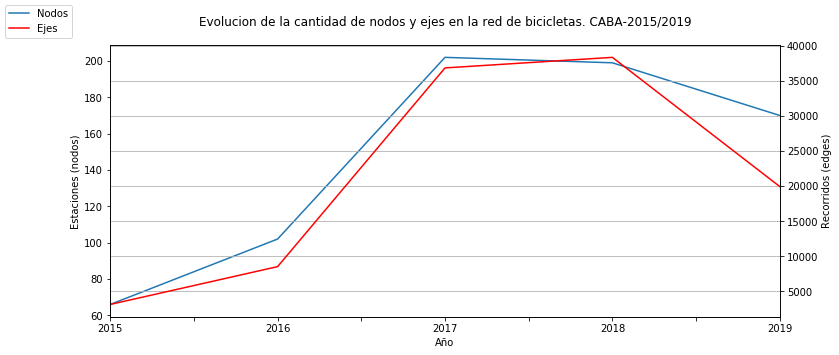

In [33]:
# Vemos como evolucionaron la cantidad de nodos y edges
ax = evolucion.plot(x="Año", y="Nodos", figsize=(12,5),legend=False)
ax2 = ax.twinx()
evolucion.plot(x="Año", y="Ejes", ax=ax2, figsize=(12,5), legend=False, color="r")
ax.figure.legend(loc='upper left')
ax.set_ylabel("Estaciones (nodos)")
ax2.set_ylabel("Recorridos (edges)")
plt.title('Evolucion de la cantidad de nodos y ejes en la red de bicicletas. CABA-2015/2019', y=1.05)
plt.grid();

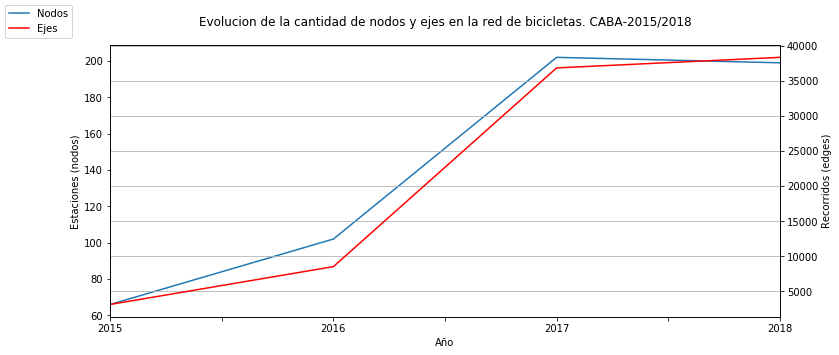

In [34]:
# Dejamos afuera a 2019 (no incluye todos los meses, solamente hasta febrero)

ax = evolucion.iloc[:4].plot(x="Año", y="Nodos", figsize=(12,5),legend=False)
ax2 = ax.twinx()
evolucion.iloc[:4].plot(x="Año", y="Ejes", ax=ax2, figsize=(12,5), legend=False, color="r")
ax.figure.legend(loc='upper left')
ax.set_ylabel("Estaciones (nodos)")
ax2.set_ylabel("Recorridos (edges)")
plt.title('Evolucion de la cantidad de nodos y ejes en la red de bicicletas. CABA-2015/2018', y=1.05)
plt.grid();

In [35]:
print('Entre 2016 y 2017, los nodos (estaciones) de la red de bicicletas de la Ciudad de Buenos Aires crecio un %s%%' % round((n17/n16-1)*100,2)) 

Entre 2016 y 2017, los nodos (estaciones) de la red de bicicletas de la Ciudad de Buenos Aires crecio un 98.04%


In [36]:
print('Por su parte, en el mismo periodo, la cantidad de recorridos (edges) de la red de bicicletas de la Ciudad de Buenos Aires crecio un %s%%'% round((e17/e16-1)*100,2))

Por su parte, en el mismo periodo, la cantidad de recorridos (edges) de la red de bicicletas de la Ciudad de Buenos Aires crecio un 332.01%


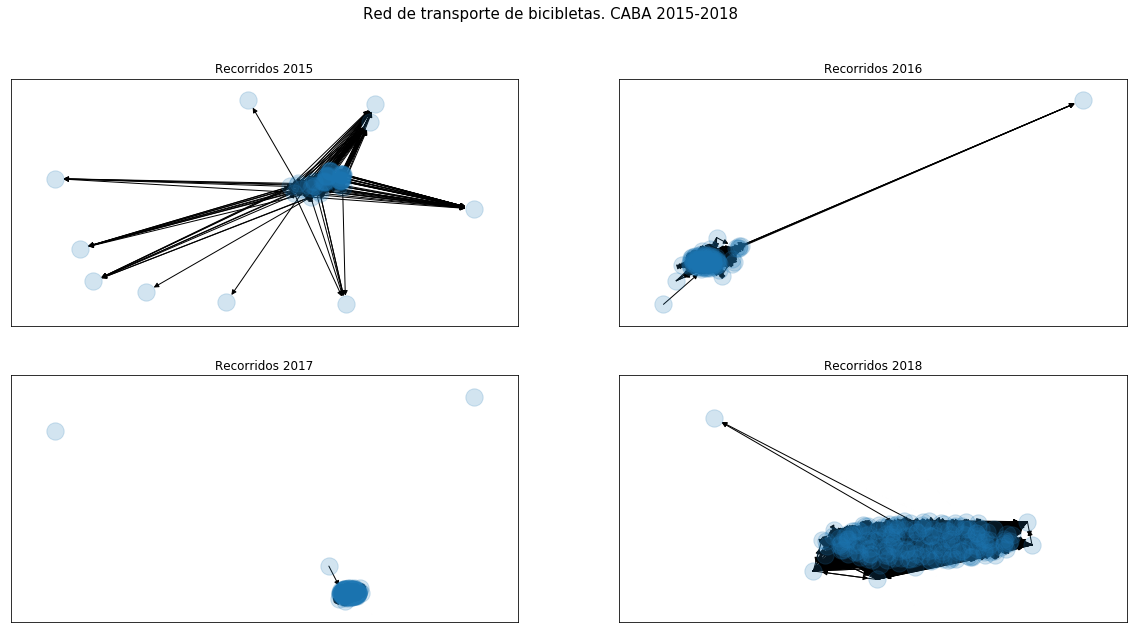

In [37]:
# Graficamos los grafos de la red de bicicletas por año
plt.figure(figsize=(20,10))

# bicigrafo2015
plt.subplot(2,2,1)
pos = nx.spring_layout(b15)
nx.draw_networkx_nodes(b15, pos, alpha=0.2, node_linewidth = 0.0,size=75)
nx.draw_networkx_edges(b15, pos, style='solid', aplha=0.1)
plt.title('Recorridos 2015')

# bicigrafo2016
plt.subplot(2,2,2)
pos2 = nx.spring_layout(b16)
nx.draw_networkx_nodes(b16, pos2, alpha=0.2, node_linewidth = 0.0,size=75)
nx.draw_networkx_edges(b16, pos2, style='solid', aplha=0.1)
plt.title('Recorridos 2016')

# bicigrafo2017
plt.subplot(2,2,3)
pos3 = nx.spring_layout(b17)
nx.draw_networkx_nodes(b17, pos3, alpha=0.2, node_linewidth = 0.0,size=75)
nx.draw_networkx_edges(b17, pos3, style='solid', aplha=0.1)
plt.title('Recorridos 2017')

# bicigrafo2018
plt.subplot(2,2,4)
pos4 = nx.spring_layout(b18)
nx.draw_networkx_nodes(b18, pos3, alpha=0.2, node_linewidth = 0.0,size=75)
nx.draw_networkx_edges(b18, pos3, style='solid', aplha=0.1)
plt.title('Recorridos 2018')

plt.suptitle('Red de transporte de bicibletas. CABA 2015-2018', fontsize=15);

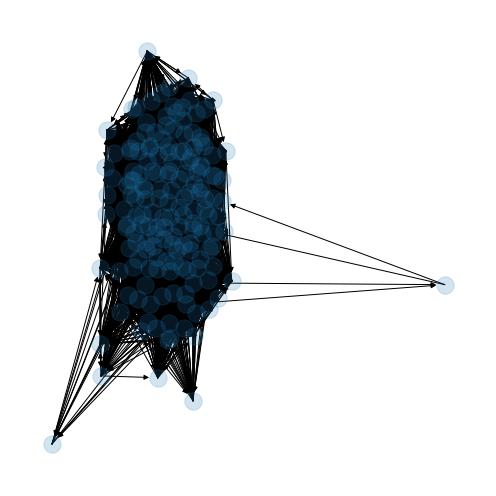

In [38]:
# Graficamos el bicigrafo19 aparte (tiene menos meses)
plt.figure(figsize=(7,7))
pos = nx.spring_layout(b19)
nx.draw_networkx_nodes(b19, pos, alpha=0.2, node_linewidth = 0.0,size=75)
nx.draw_networkx_edges(b19, pos, style='solid', aplha=0.1)
plt.axis('off')
plt.tight_layout()
plt.show()

In [39]:
# Direccionalidad de la red. Creamos una funcion para devolver el porcentaje de viajes dirigidos y selfloops

def direccionalidad(df, origen, destino):
    
    # se usa size() y no count() por si hubiera null cases
    agrupado = df.groupby([origen,destino]).size().reset_index(name='recorridos')
    agrupado.columns = ['origen','destino','recorridos']
    
    labels = ['SELF-LOOP', 'DIRIGIDO']
    sizes = [agrupado.loc[agrupado['origen']==agrupado['destino']]['recorridos'].sum(), 
             agrupado.loc[agrupado['origen']!=agrupado['destino']]['recorridos'].sum()]
    colors = ['#B7B8B6', '#4CB5F5']
    explode = (0.09, 0)
    
    plt.figure(figsize=(15,6))
    plt.pie(sizes, explode=explode, labels=None, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140, pctdistance = 0.5)
 
    plt.legend(labels, loc=(0.22,0.1))
    plt.axis('equal')
    plt.title('Tipo de recorrido - ECOBICI-CABA', y=0.98)
    
    return plt.show()

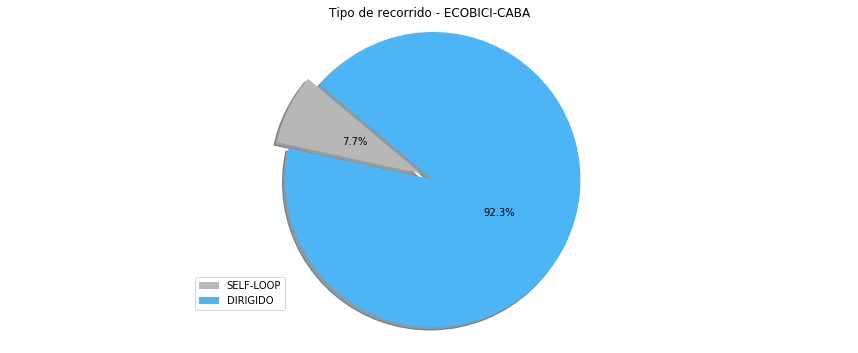

In [40]:
# Testeamos la funcion con 2018. La mayoria de los viajes son saliendo de una estacion y llegando a otra
direccionalidad(df18,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

In [41]:
# Creamos una funcion que nos devuelva el par de estaciones con mayor cantidad de recorridos realizados
def tipo_de_viajes(df,origen,destino):
    
    # se usa size() y no count() por si hubiera null cases
    agrupado = df.groupby([origen,destino]).size().reset_index(name='recorridos')
    agrupado.columns = ['origen','destino','recorridos']
    
    estaciones = agrupado.sort_values(by='recorridos', ascending=False).head()
    
    return estaciones

In [42]:
# Vemos el tipo de recorrido con mayor cantidad de viajes durante 2018
tipo_de_viajes(df18,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

origen                  destino  recorridos
23386                 Pacífico                 Pacífico        4848
28224             Plaza Italia             Plaza Italia        4757
37556            Vera Peñaloza            Vera Peñaloza        4477
23978        Parque Centenario        Parque Centenario        4131
13504  Godoy Cruz y Libertador  Godoy Cruz y Libertador        4033

En este punto, podemos ver que los viajes con mismo origen y destino son los que mayor cantidad de recorridos realizados tienen. Es decir que, si bien los self-loops tienen una representación menor en cantidad de viajes (para 2018, alrededor del 8%), analizados individualmente tienen una frecuencia de recorridos realizados mucho mayor que los viajes dirigidos. En otras palabras, para 2018 la cantidad de viajes dirigidos fue mayor a los "autodirigidos" pero con una frecuencia individual mucho menor.

In [43]:
# Corroboramos lo anterior (2018). Los viajes dirigidos son mas en cantidad pero con frecuencias de recorridos mucho menores!
agrupado.sort_values(by='recorridos', ascending=True).head()

origen                destino  recorridos
37668      Villarroel                 Moreno           1
28023   Plaza Houssay  Pinzon y M. Rodriguez           1
36916  Usina del Arte             Planetario           1
17566     Jose Marmol     Hospital Rivadavia           1
36917  Usina del Arte         Plaza Alemania           1

In [44]:
# Promedio de de cantidad de recorridos realizados por tipo de viaje: autodirigidos 2018
agrupado.loc[agrupado['origen']==agrupado['destino']]['recorridos'].mean()

1141.035175879397

In [45]:
# Promedio de de cantidad de recorridos realizados por tipo de viaje: dirigidos 2018
agrupado.loc[agrupado['origen']!=agrupado['destino']]['recorridos'].mean()

71.45553953061491

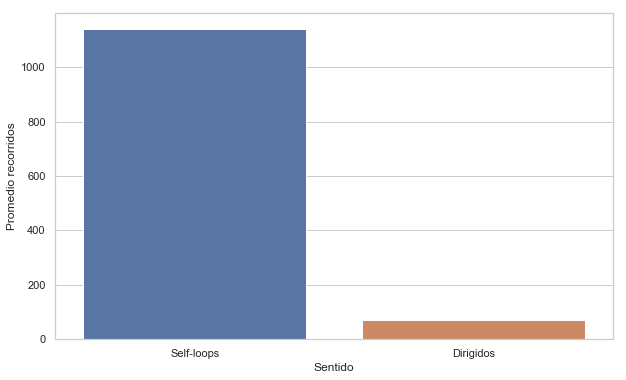

In [46]:
# Promedio de recorridos realizado por sentido de la conexion: self-loops y dirigidos

plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.barplot(x="Sentido", y="Promedio recorridos", 
            data=pd.DataFrame({'Sentido': ['Self-loops','Dirigidos'], 'Promedio recorridos':[1141,72]}));

Evidentemente esto es una característica estructural de la red de bicicletas. Hay muchos viajes direccionados que, individualmente, tienen pocos recorridos realizados. Por otra parte, los viajes autodirigidos son menores en cantidad de casos (algo lógico por la cantidad de estaciones y las combinaciones posibles que esto permite) pero con frecuencia de recorridos mucho mayor. Los mismos resultados se pueden corroborar para otros años. A modo de ejemplo, vemos qué ocurrió durante 2015.Este análisis podría aplicarse para cualquiera de los años disponibles y obtener seguramente los mismos resultados.

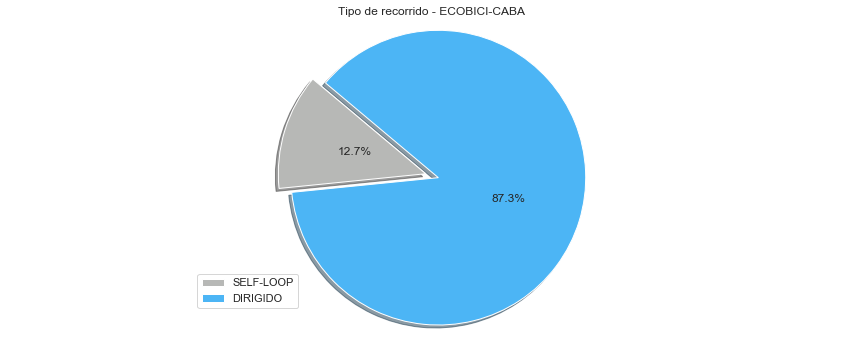

In [47]:
# Probamos las mismas funciones para 2015
direccionalidad(df15,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

In [48]:
tipo_de_viajes(df15,'bici_nombre_estacion_origen','bici_nombre_estacion_destino')

origen            destino  recorridos
1591           Pacífico           Pacífico        5091
1716   Parque Las Heras   Parque Las Heras        4340
1654  Parque Centenario  Parque Centenario        4061
1120        Juana Manso        Juana Manso        3653
2311       Plaza Italia       Plaza Italia        3573

Tanto en 2015 como en 2018, la estación con mayor cantidad de recorridos fue Pacífico. Esta estación se encuantra en Santa Fé y Juan B.Justo. Entre las principales características de la zona se puede mencionar su proximidad con Plaza Italia y Palermo Hollywood.

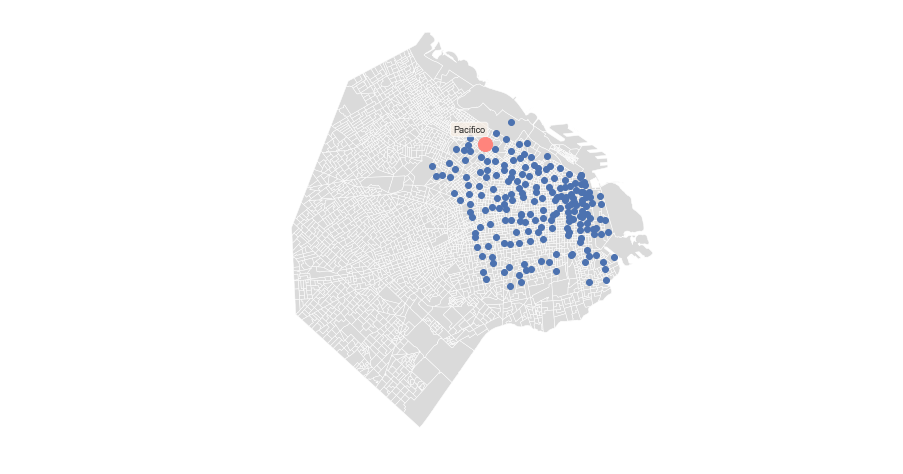

In [109]:
# radios censales caba
caba = gpd.read_file('data/informacion_censal_por_radio_2010.shp')

# ploteamos la estacion Pacifico
f, ax = plt.subplots(1,figsize=(15,8))

caba.plot(ax=ax, linewidth=0.5, color='#dadada')
estaciones.to_crs(crs=caba.crs).plot(ax=ax,marker='o')
pacifico = estaciones.loc[estaciones['NOMBRE']=='Pacífico'] 
pacifico.to_crs(crs=caba.crs).plot(ax=ax,marker='o', color='#FF847C', markersize=200)


props = dict(boxstyle='round', facecolor='linen', alpha=0.7)
for point in pacifico.to_crs(crs=caba.crs).iterrows():
    ax.text(point[1]['geometry'].centroid.x+20,
            point[1]['geometry'].centroid.y+600,
            point[1]['NOMBRE'],
            horizontalalignment='right',
            fontsize=9,
            bbox=props)    
    
    
plt.axis('equal')
ax.set_axis_off()

## Medidas de conexion de la red

Según Cardozo, Gómez y Parras (2009), el grado de comunicación recíproca entre los nodos de una red puede ser interpretada como el nivel de conexión (o cohesión en términos territoriales) que esta presenta para su funcionamiento interno. Es decir que, cuantos más arcos tenga el grafo, mayor será el grado de conectividad. Asimismo, esto indica la mayor o menor complejidad estructural de la red, lo cual está ligado directamente al número de nodos, arcos y a su disposición espacial  

El interés por esta clase de medidas,obedece a que el incremento de las conexiones a través del tiempo significa una mayor cohesión espacial para el territorio donde se emplaza la red

A continuación se presentan algunos índices extraídos del estudio de Cardozo, Gómez y Parras (2009). El mismo se encuentra disponible en http://revistascientificas.filo.uba.ar/index.php/rtt/article/view/223

1) Índice Beta de Kanskyexpresala: β = a / n

       Logra medir como aumenta la conectividad cuando se incrementa el número de arcos de un grafo (Seguí Pons y Petrus Bey, 1991). Las redes de transporte de estructura muy compleja asumen valores de índice β más elevados, mientras las redes cuya estructura es más sencilla, tendrán valores más bajos(Potrykowsky, 1984).


In [51]:
# Creamos funcion para el indice Beta
def cohesion(grafo):
    '''
    Devuelve el grado de conectividad de una red
    '''
    a = len(grafo.edges())
    n = len(grafo.nodes())
    beta = round(a/n, 2)
    return beta

In [52]:
# Creamos una lista con todos los grafos que queremos incluir en el indice
grafos = [b15,b16,b17,b18,b19]

# Calculamos el nivel de cohesion de la red y almacenamos el resultado en una lista
indice1 = [cohesion(i) for i in grafos]

In [53]:
indice1

[47.56, 83.58, 182.32, 192.63, 117.21]

2) El Índice Gamma: ɣ = a/(n*(n-1)/2)

       Relaciona el número de arcos existentes y el número máximo que puede existir dentro de un grafo determinado, teniendo en cuenta la cantidad de nodos de una red.  


In [54]:
# Funcion para calcular Beta max
def cohesion_max(grafo):
    '''
    Devuelve el porcentaje respecto del maximo posible de beta. Es una medida complementaria de cohesion
    '''
    a = len(grafo.edges())
    n = len(grafo.nodes())
    beta_max= a/(n*(n-1)/2)
    return beta_max    

In [55]:
# Calculamos el nivel de cohesion respecto del maximo posible de Beta y almacenamos el resultado en una lista
indice2 = [cohesion_max(i) for i in grafos]

In [56]:
indice2

[1.4634032634032634,
 1.6550184430207726,
 1.814147086350426,
 1.945789553829755,
 1.3871214758092587]

3) El Número Ciclomático: μ = a – (n – 1) – g

       Determina la cantidad de circuitos que existen dentro de un grafo. Entendiendo por circuito, cada una de las múltiples maneras que existen para ir desde un nodo hasta el mismo, sin tener que pasar dos veces por el mismo arco. Se calcula restando el número total de arcos (a) al número de nodos necesario para formar un árbol (n-1), restándose además los grafos inconexos(g)que puedan existir (Bosque Sendra, 1992)

In [57]:
# Funcion para calcular el node degree de cada grafo. Se puede usar la misma estructura para pasar otras labels y valores a los nodos.

def grado_nodo(grafo):
    '''
    Funcion para calcular el grado de cada nodos y pasarselo como 'label/value'
    '''
    
    for n, d in grafo.nodes(data=True):
        
        # Calcula el grado para cada nodo
        grafo.node[n]['degree'] = nx.degree(grafo,n)

In [58]:
# Aplicamos la funcion a todos los nodos con una lista por comprension
[grado_nodo(i) for i in grafos]

[None, None, None, None, None]

In [59]:
# Creamos una funcion para calcular el nro. ciclomatico de cada grafo
def ciclomatico(grafo):
    '''
    Devuelve el Numero Ciclomatico de un grafo
    '''
    a = len(grafo.edges())
    n = len(grafo.nodes())
    # Filtra por condicion del label del nodo y devuelve la cantidad de True (en este caso, nodos solitarios)
    g = len([n for n,d in grafo.nodes(data=True) if d['degree'] <1])
    u = a - (n - 1) - g
    return u

In [60]:
indice3 = [ciclomatico(i) for i in grafos]

In [61]:
indice3

[3074, 8424, 36628, 38136, 19757]

4) El Índice Alfa: α = (μ / 2 ∙ n – 5) ∙ 100

        Relaciona el número de circuitos observados en el grafo (µ) y los circuitos que existirán en caso de tratarse de un grafo completo. Se trata de una comparacion respecto del número máximo posible de circuitos en la red. Es un indicador de la complejidad de la red, que se obtiene del ratio entre el Número Ciclomático y el máximo posible de circuitos.

In [62]:
# Creamos una funcion para el indice alpha
def alpha(grafo):
    
    def ciclomatico(grafo):
        a = len(grafo.edges())
        n = len(grafo.nodes())
        # Filtra por condicion del label del nodo y devuelve la cantidad de True (en este caso, nodos solitarios)
        g = len([n for n,d in grafo.nodes(data=True) if d['degree'] <1])
        u = a - (n - 1) - g
        return u, n
    u = ciclomatico(grafo)[0]
    n = ciclomatico(grafo)[1]
    a = u/(2*n-5)
    return a

In [63]:
indice4 = [alpha(i) for i in grafos]

In [64]:
indice4

[24.20472440944882,
 42.33165829145729,
 91.79949874686717,
 97.0381679389313,
 58.97611940298508]

In [65]:
#Indices de cohesion
indices = pd.DataFrame({'Año':['2015','2016','2017','2018','2019'],'Beta':indice1, 'Beta_max': indice2, 'Ciclo': indice3, 'Alpha': indice4})

In [66]:
indices

Año    Beta  Beta_max  Ciclo      Alpha
0  2015   47.56  1.463403   3074  24.204724
1  2016   83.58  1.655018   8424  42.331658
2  2017  182.32  1.814147  36628  91.799499
3  2018  192.63  1.945790  38136  97.038168
4  2019  117.21  1.387121  19757  58.976119

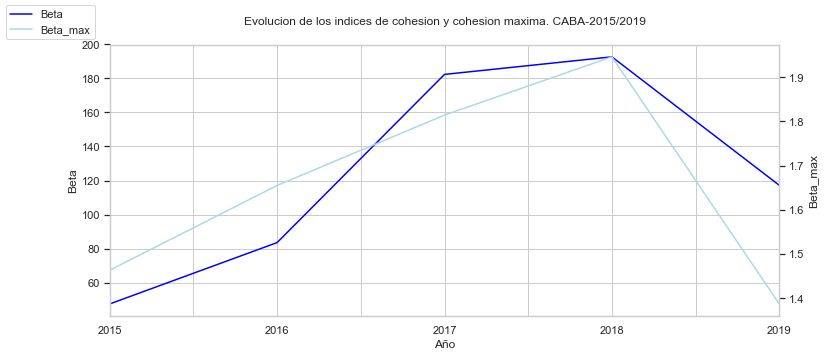

In [67]:
# Vemos como los indices de cohesion
ax = indices.plot(x="Año", y="Beta", figsize=(12,5),legend=False,color='Blue')
ax2 = ax.twinx()
indices.plot(x="Año", y="Beta_max", ax=ax2, figsize=(12,5), legend=False, color="lightblue")
ax.figure.legend(loc='upper left')
ax.set_ylabel("Beta")
ax2.set_ylabel("Beta_max")
plt.title('Evolucion de los indices de cohesion y cohesion maxima. CABA-2015/2019', y=1.05)
plt.grid();

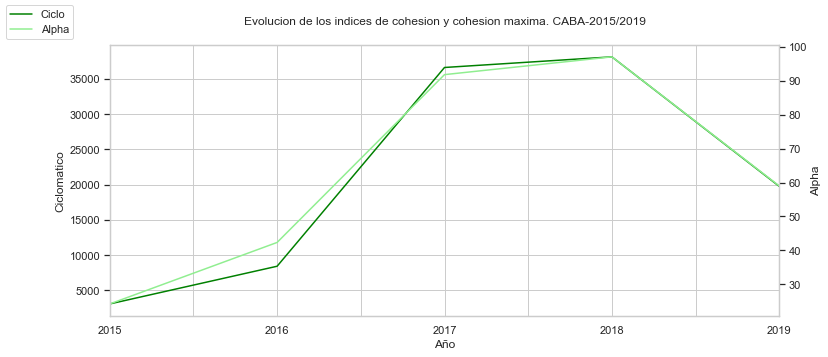

In [68]:
# Vemos como evolucionaron el numero ciclomatico y el indice alpha
ax = indices.plot(x="Año", y="Ciclo", figsize=(12,5),legend=False,color='Green')
ax2 = ax.twinx()
indices.plot(x="Año", y="Alpha", ax=ax2, figsize=(12,5), legend=False, color="lightgreen")
ax.figure.legend(loc='upper left')
ax.set_ylabel("Ciclomatico")
ax2.set_ylabel("Alpha")
plt.title('Evolucion de los indices de cohesion y cohesion maxima. CABA-2015/2019', y=1.05)
plt.grid();

El valor agregado de estos índices radica en la posibilidad de comparar o bien dos redes de características similares o la misma a lo largo del tiempo. Ahora bien, no nos dice otra cosa de lo que ya habíamos confirmado: la red de bicicletas de la Ciudad aumentó tanto en cantidad de estaciones como de recorridos realizados entre ellas. En otras palabras, en cantidad de nodos y ejes.

## Medidas de Accesibilidad y Centralidad

En una red de transporte, la cantidad de arcos que es necesario atravesar para llegar a un nodo de referencia desde cualquier otro puede darnos una idea de la accesibilidad topológica con la que cuenta cada nodo en la red. En un sistema público de bicicletas, la posibilidad de ir de un nodo a cualquier otro modifica un poco este concepto, ya que las relaciones entre ellos suele ser "uno a uno". Es decir, una estación de origen y otra de destino. No obstante, la cantidad de estaciones con las que se conecta y la frecuencia de viajes con las que cuenta un recorrido sí puede darnos una idea de la centralidad con la que cuenta un nodo dentro de la red. En otras palabras, la cantidad de conexiones entrantes y salientes, el grado del nodo, el promedio de conexiones (entre otras) son medidas que pueden ayudar a entender los patrones de uso principal dentro de la red de bicicletas. 

In [69]:
# Librerias (visualizacion grafos)
import nxviz as nv

### Matriz de conectividad 

...una tabla simétrica donde se indica con 1 las relaciones directas entre nodos y con 0 la ausencia de una conexión directa.

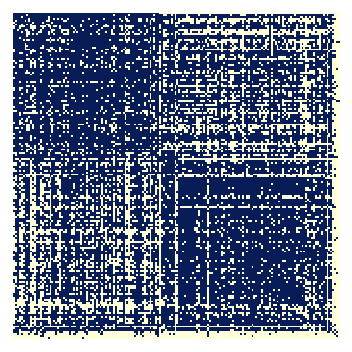

In [70]:
m = nv.MatrixPlot(b19)

# Draw m to the screen
m.draw()

# Display the plot
plt.show()

''

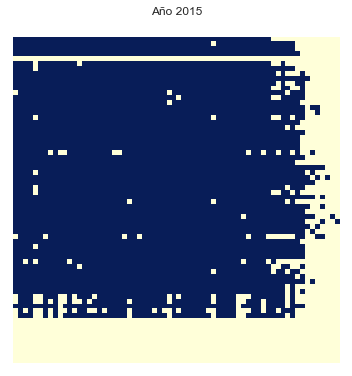

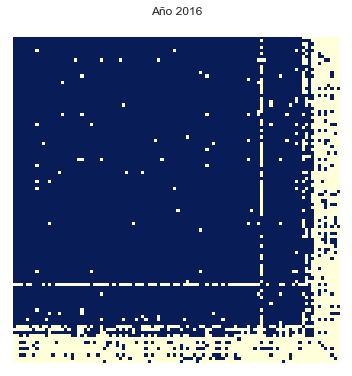

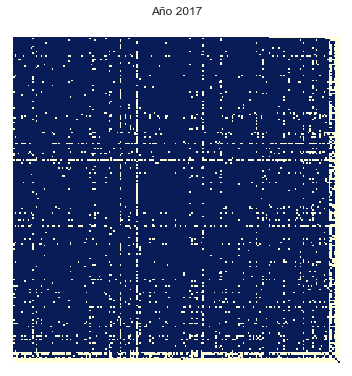

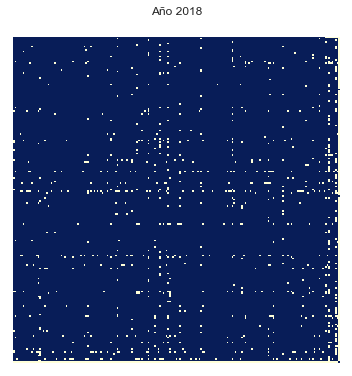

In [71]:
# El problema de graficar con nxviz es que crea su propio plot, con lo cual siempre queda afuera de cualquier subplot

# bicigrafo2015
m15 = nv.MatrixPlot(b15)
m15.draw()
plt.title('Año 2015')

# bicigrafo2016
m16 = nv.MatrixPlot(b16)
m16.draw()
plt.title('Año 2016')

# bicigrafo2017
m17 = nv.MatrixPlot(b17)
m17.draw()
plt.title('Año 2017')

# bicigrafo2018
m18 = nv.MatrixPlot(b18)
m18.draw() 
plt.title('Año 2018')

;

Se puede apreciar que, conforme avanzan los años la matriz de interacciones se expande cada vez mas. Esto parece tener cierto correlato con la forma o topologia del grafo. A continuacion se agregan algunas relaciones (la libreria no es muy comoda para graficar)

In [72]:
# Librerias (visualizacion)
import matplotlib.pyplot as plt 
import matplotlib.gridspec 

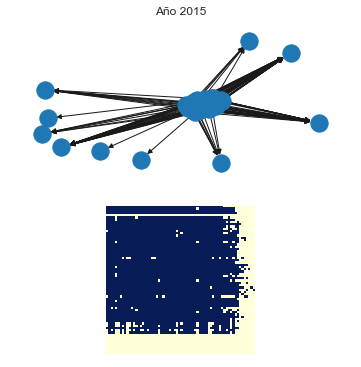

In [73]:
#2015
m = nv.MatrixPlot(b15)
m.draw()


gs = matplotlib.gridspec.GridSpec(2,1)
plt.gca().set_position(gs[1].get_position(plt.gcf()))
plt.gca().set_subplotspec(gs[1])

plt.subplot(gs[0])
nx.draw(b15)
plt.title('Año 2015', y=1.05)
plt.show()

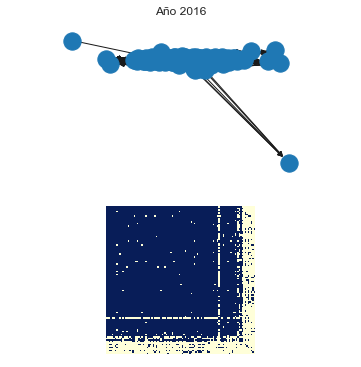

In [74]:
#2016
m2 = nv.MatrixPlot(b16)
m2.draw()


gs = matplotlib.gridspec.GridSpec(2,1)
plt.gca().set_position(gs[1].get_position(plt.gcf()))
plt.gca().set_subplotspec(gs[1])

plt.subplot(gs[0])
nx.draw(b16)
plt.title('Año 2016', y=1.05)

plt.show()

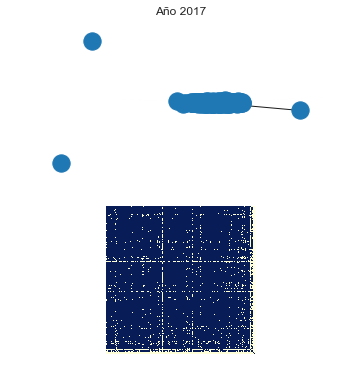

In [75]:
#2017
m3 = nv.MatrixPlot(b17)
m3.draw()


gs = matplotlib.gridspec.GridSpec(2,1)
plt.gca().set_position(gs[1].get_position(plt.gcf()))
plt.gca().set_subplotspec(gs[1])

plt.subplot(gs[0])
nx.draw(b17)
plt.title('Año 2017', y=1.05)

plt.show()

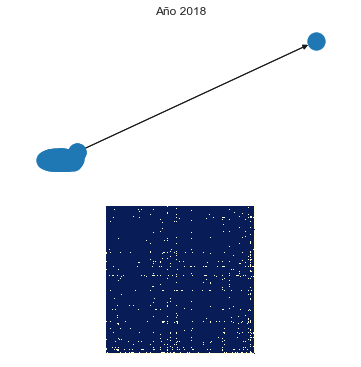

In [76]:
#2018
m4 = nv.MatrixPlot(b18)
m4.draw()


gs = matplotlib.gridspec.GridSpec(2,1)
plt.gca().set_position(gs[1].get_position(plt.gcf()))
plt.gca().set_subplotspec(gs[1])

plt.subplot(gs[0])
nx.draw(b18)
plt.title('Año 2018', y=1.05)

plt.show()

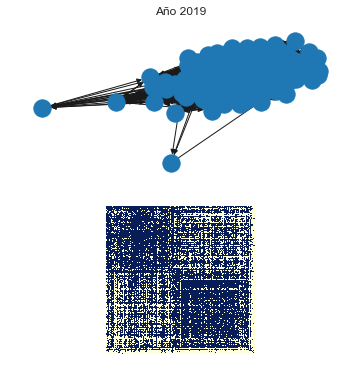

In [77]:
#2019
m5 = nv.MatrixPlot(b19)
m5.draw()


gs = matplotlib.gridspec.GridSpec(2,1)
plt.gca().set_position(gs[1].get_position(plt.gcf()))
plt.gca().set_subplotspec(gs[1])

plt.subplot(gs[0])
nx.draw(b19)
plt.title('Año 2019', y=1.05)

plt.show()

### Conexiones por nodo y año... 

In [78]:
# Creamos una funcion para devolver un dataframe con la cantidad de otros nodos que se conecta cada nodo
def matriz(grafo):
    '''
    Devuelve un dataframe con la matriz de relaciones entre nodos
    '''
    
    conexiones = nx.to_numpy_matrix(grafo)
    df = pd.DataFrame(conexiones)
    
    est_label = []
    [est_label.append(n) for n,d in grafo.nodes(data=True)]
    df['TOTAL'] = df[:].sum()
    df['ESTACION'] = est_label
    return df

In [79]:
# Aplicamos la funcion a la red de 2015
dfm15 = matriz(b15)

In [80]:
# Como se ve, la matriz devuelve con cuantas estaciones se conecto cada estacion
# Esmeralda, Hospital Italiano y A.Figueroa, las estaciones con menor presencia de conexiones direccionadas
dfm15.sort_values(by='TOTAL', ascending=True).head()

0    1    2    3    4    5    6    7    8    9  ...   58   59   60   61  \
65  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
63  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
64  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
62  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
61  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

     62   63   64   65  TOTAL               ESTACION  
65  0.0  0.0  0.0  0.0    1.0              Esmeralda  
63  0.0  0.0  0.0  0.0    1.0      Hospital Italiano  
64  0.0  0.0  0.0  0.0    1.0      Acuña de Figueroa  
62  0.0  0.0  0.0  0.0    5.0  Sánchez de Bustamante  
61  0.0  0.0  0.0  0.0    6.0                Padilla  

[5 rows x 68 columns]

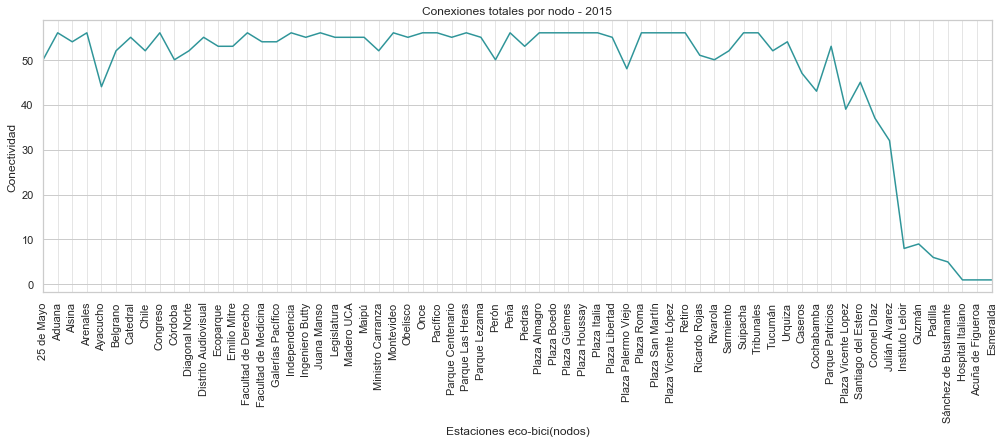

In [81]:
# Graficamos las conexiones por nodo
dfm15.plot(x='ESTACION', y='TOTAL',figsize=(17,5), color='#2F9599', legend=False)
plt.title('Conexiones totales por nodo - 2015')
plt.xlabel('Estaciones eco-bici(nodos)')
plt.ylabel('Conectividad')
plt.xticks(np.arange(len(dfm15)),dfm15['ESTACION'] , rotation=90)
plt.grid(axis='x', alpha=0.5);

In [82]:
# Aplicamos la funcion a la red de 2016
dfm16 = matriz(b16)

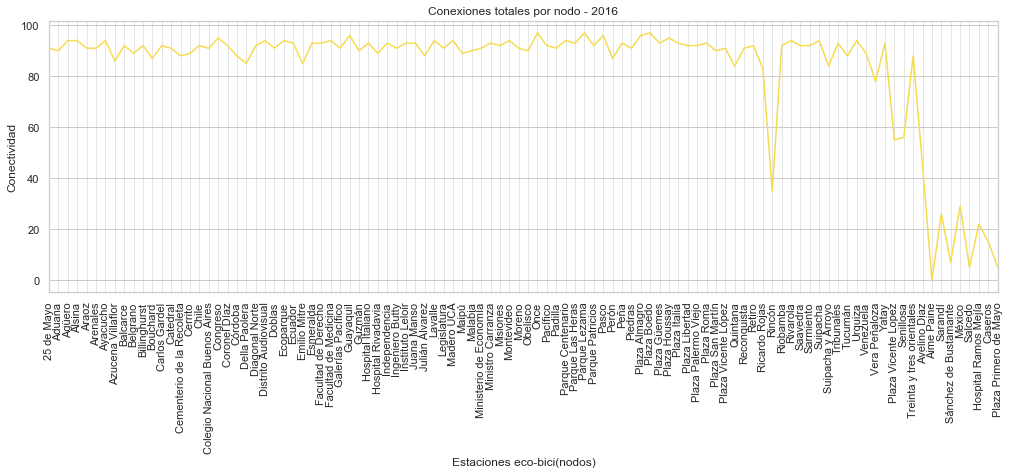

In [83]:
# Graficamos
dfm16.plot(x='ESTACION', y='TOTAL',figsize=(17,5), color='#F7DB4F', legend=False)
plt.title('Conexiones totales por nodo - 2016')
plt.xlabel('Estaciones eco-bici(nodos)')
plt.ylabel('Conectividad')
plt.xticks(np.arange(len(dfm16)),dfm16['ESTACION'] , rotation=90)
plt.grid(axis='x', alpha=0.5);

In [84]:
# Aplicamos la funcion a la red de 2017
dfm17 = matriz(b17)

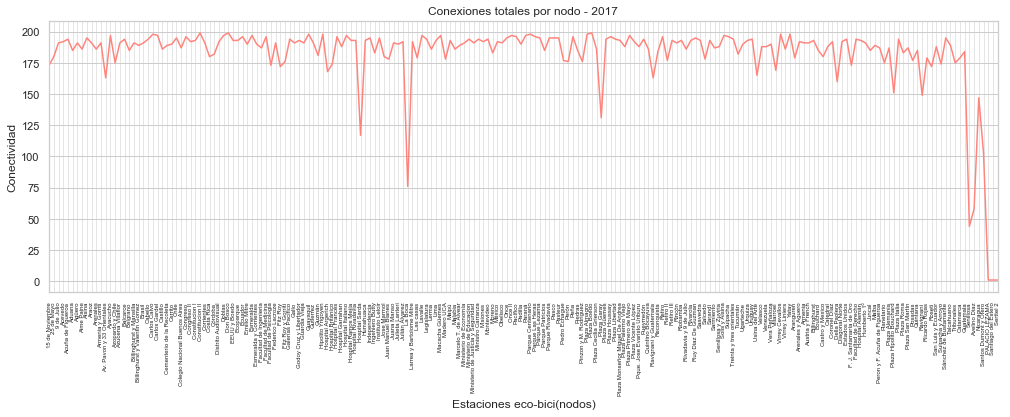

In [85]:
# Graficamos
dfm17.plot(x='ESTACION', y='TOTAL',figsize=(17,5),  color='#FF847C', legend=False)
plt.title('Conexiones totales por nodo - 2017')
plt.xlabel('Estaciones eco-bici(nodos)')
plt.ylabel('Conectividad')
plt.xticks(np.arange(len(dfm17)),dfm17['ESTACION'], fontsize=6, rotation=90)
plt.grid(axis='x', alpha=0.5);

In [86]:
# Aplicamos la funcion a la red de 2018
dfm18 = matriz(b18)

In [87]:
# En 2018, PALACIO LEZAMA fue la estacion con menor presencia de conexiones direccionadas (otras estaciones)
dfm18.sort_values(by='TOTAL', ascending=True).head()

0    1    2    3    4    5    6    7    8    9  ...  191  192  193  \
198  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
196  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  0.0  1.0   
192  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
94   1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  ...  1.0  1.0  1.0   
82   1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...  1.0  0.0  1.0   

     194  195  196  197  198  TOTAL                 ESTACION  
198  0.0  0.0  0.0  0.0  1.0    3.0           PALACIO LEZAMA  
196  0.0  1.0  1.0  1.0  0.0  138.0    Santos Dumont y Otero  
192  1.0  1.0  0.0  1.0  0.0  140.0  Plaza Hipolito Bouchard  
94   1.0  1.0  0.0  1.0  0.0  170.0                  La Boca  
82   1.0  0.0  1.0  0.0  0.0  172.0           Hospital Sarda  

[5 rows x 201 columns]

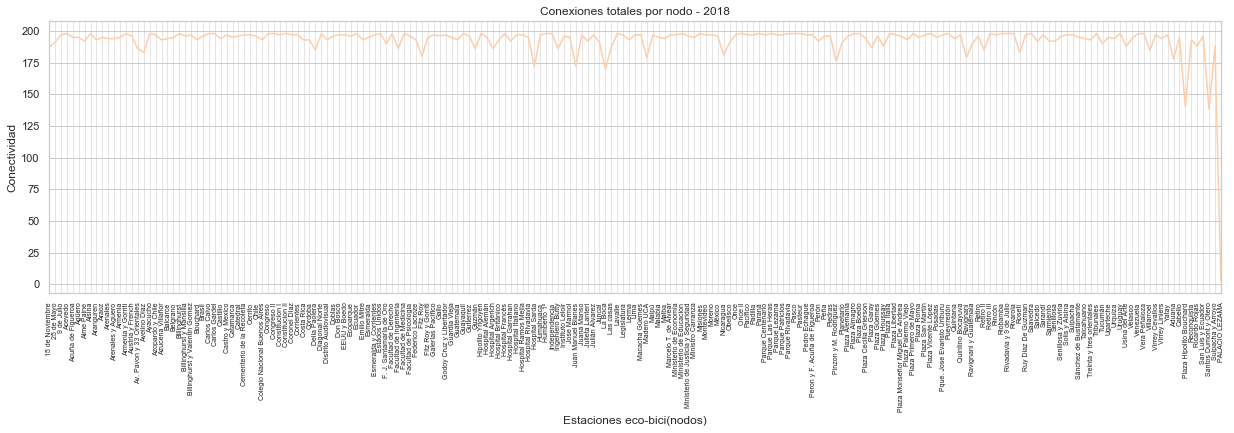

In [88]:
# Graficamos
dfm18.plot(x='ESTACION', y='TOTAL',figsize=(21,5), color='#FECEAB', legend=False)
plt.title('Conexiones totales por nodo - 2018')
plt.xlabel('Estaciones eco-bici(nodos)')
plt.ylabel('Conectividad')
plt.xticks(np.arange(len(dfm18)),dfm18['ESTACION'],fontsize=7, rotation=90)
plt.grid(axis='x', alpha=0.5);

En los ultimos años el nivel de conectividad entre nodos parece volverse más homogéneo (menos diferencias entre nodos). Excluimos de este análisis a la red de 2019 por tener sólo dos meses.

In [89]:
# # Aplicamos la funcion a la red de 2019
dfm19 = matriz(b19)

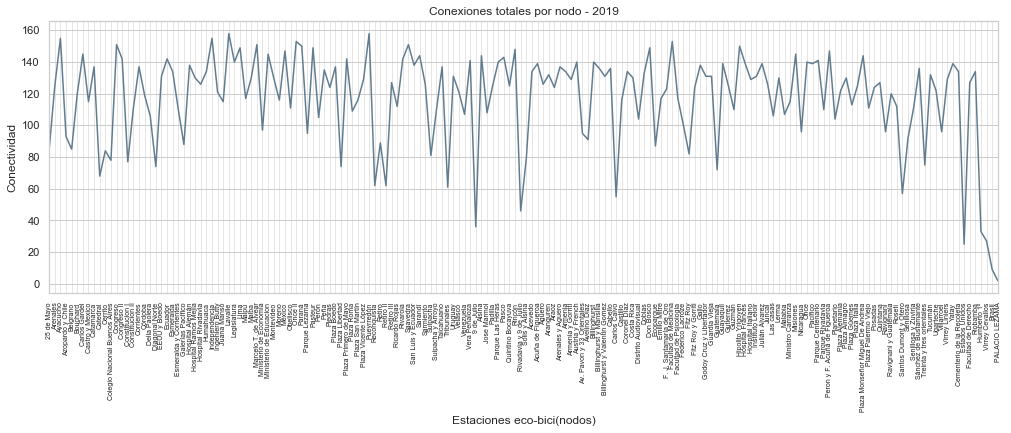

In [90]:
# Graficamos
dfm19.plot(x='ESTACION', y='TOTAL',figsize=(17,5), color='#607c8e', legend=False)
plt.title('Conexiones totales por nodo - 2019')
plt.xlabel('Estaciones eco-bici(nodos)')
plt.ylabel('Conectividad')
plt.xticks(np.arange(len(dfm19)),dfm19['ESTACION'] , fontsize=7, rotation=90)
plt.grid(axis='x', alpha=0.5);

**...recordemos que es el node degree de un grafo:**

![caption](img/node_degree.png)

In [91]:
# Creamos una funcion para devolver un dataframe con el node degree por grafo
def ndg(grafo):
    '''
    Devuelve un df con cada nodo, su degree, in_degree y out_degree
    '''
    
    ndg = grafo.degree()
    idg = grafo.in_degree()
    odg = grafo.out_degree()
    
    estacion = [k for k,v in ndg]
    in_degree = [v for k,v in idg]
    out_degree = [v for k,v in odg]
    node_degree = [v for k,v in ndg]
    
    df = pd.DataFrame(estacion).reset_index()
    df.drop(columns='index', inplace=True)
    df.columns = ['estacion']
    df['in_degree'],df['out_degree'],df['node_deg'] = in_degree, out_degree, node_degree
    
    return df

In [92]:
# Se observa que el node_degree en nuestro grafo, al ser dirigido, equivale a la suma del lin y el out
ndg(b15).sort_values(by='node_deg', ascending=False).head()

estacion  in_degree  out_degree  node_deg
26           Once         56          63       119
32           Peña         56          62       118
38   Plaza Italia         56          61       117
37  Plaza Houssay         56          61       117
36   Plaza Güemes         56          61       117

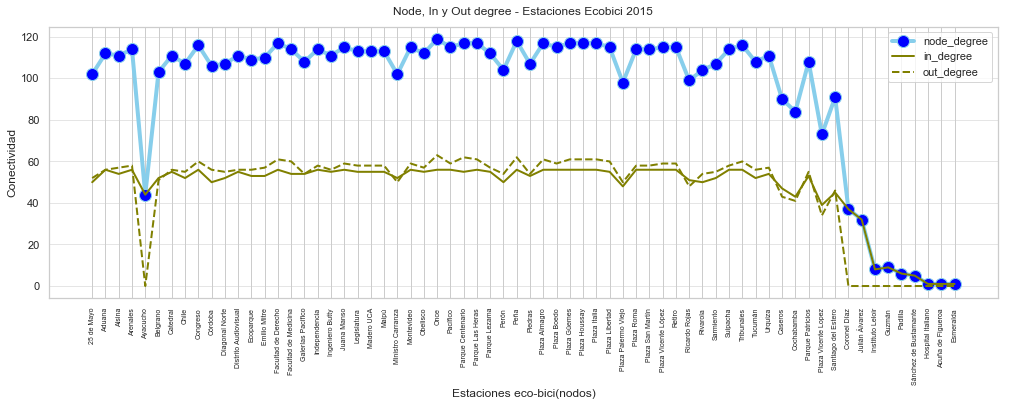

In [93]:
# Instanciamos la funcion
ndg15 = ndg(b15)
# Graficamos el node, el in y el out degree para 2015
plt.figure(figsize=(17,5))
plt.plot('estacion', 'node_deg', data=ndg15, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label='node_degree')
plt.plot('estacion', 'in_degree', data=ndg15, marker='', color='olive', linewidth=2)
plt.plot('estacion', 'out_degree', data=ndg15, marker='', color='olive', linewidth=2, linestyle='dashed')
plt.legend()
plt.title('Node, In y Out degree - Estaciones Ecobici 2015',y=1.02)
plt.xlabel('Estaciones eco-bici(nodos)')
plt.ylabel('Conectividad')
plt.xticks(np.arange(len(ndg15)),ndg15['estacion'] , fontsize=7, rotation=90)
plt.grid(axis='y', alpha=0.5);

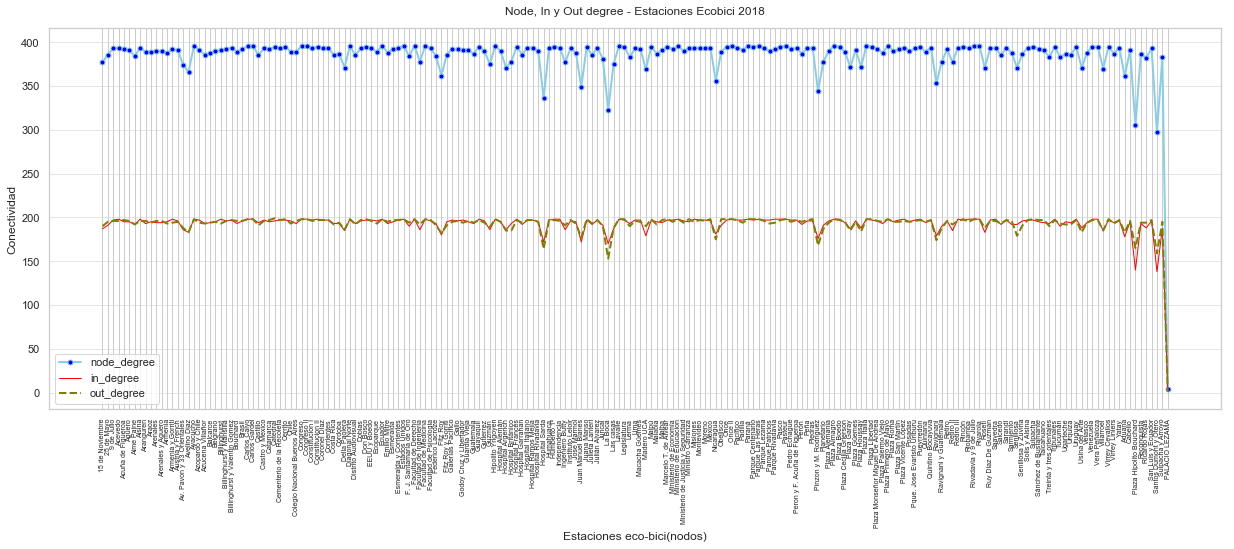

In [94]:
# Instanciamos la funcion y repetimos el grafico para 2018
ndg18 = ndg(b18)

plt.figure(figsize=(21,7))
plt.plot('estacion', 'node_deg', data=ndg18, marker='o', markerfacecolor='blue', markersize=5, color='skyblue', linewidth=2, label='node_degree')
plt.plot('estacion', 'in_degree', data=ndg18, marker='', color='red', linewidth=1)
plt.plot('estacion', 'out_degree', data=ndg18, marker='', color='olive', linewidth=2, linestyle='dashed')
plt.legend()
plt.title('Node, In y Out degree - Estaciones Ecobici 2018',y=1.02)
plt.xlabel('Estaciones eco-bici(nodos)')
plt.ylabel('Conectividad')
plt.xticks(np.arange(len(ndg18)),ndg18['estacion'] , fontsize=7, rotation=90)
plt.grid(axis='y', alpha=0.5);

In [ ]:
TAMBIEN SE PODRIA PROBAR EL GRADO PROMEDIO POR ESTACION. ES DECIR, CON CUANTOS OTROS NODOS SE CONECTA (EN PROMEDIO) CADA ESTACION

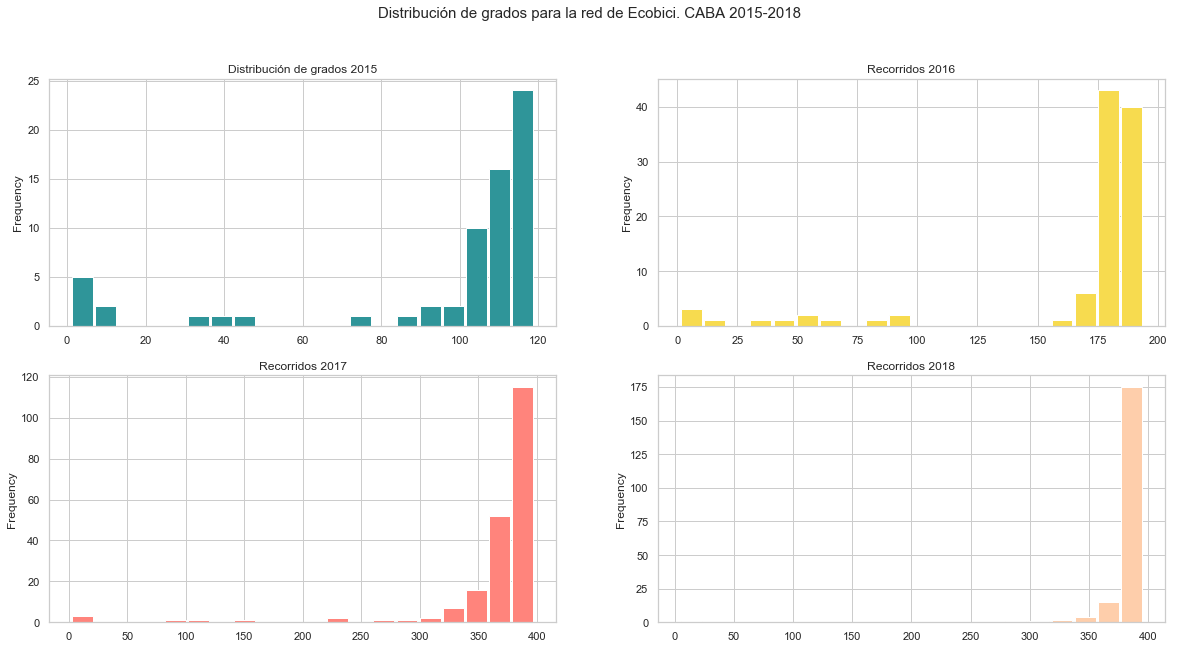

In [95]:
# Graficamos un histograma por año para ver la distribucion del grado por año
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
grados15 = pd.Series([b15.degree(n) for n in b15.nodes()])
grados15.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#2F9599')
plt.title('Distribución de grados 2015')

plt.subplot(2,2,2)
grados16 =  pd.Series([b16.degree(n) for n in b16.nodes()])
grados16.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#F7DB4F')
plt.title('Recorridos 2016')

plt.subplot(2,2,3)
grados17 =  pd.Series([b17.degree(n) for n in b17.nodes()])
grados17.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#FF847C')
plt.title('Recorridos 2017')

plt.subplot(2,2,4)
grados18 =  pd.Series([b18.degree(n) for n in b18.nodes()])
grados18.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#FECEAB')
plt.title('Recorridos 2018')

plt.suptitle('Distribución de grados para la red de Ecobici. CABA 2015-2018', fontsize=15);

El histograma muestra un emparejamiento en el esquema de conexiones. Al igual la matriz de adyacencias, el node degree muestra que el sistema público de bicicletas se ha ido expandiendo no sólo en cantidad de estaciones sino también en usabilidad. Es decir, en cantidad de conexiones (o bien recorridos realizados entre estaciones).

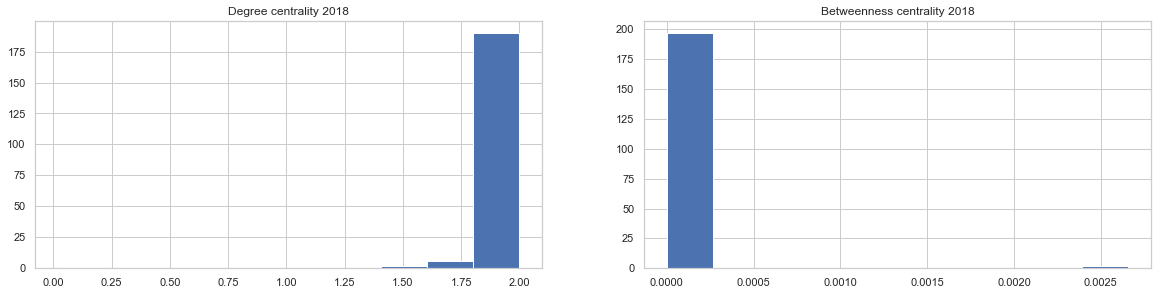

In [96]:
# Ploteamos el degree y el betweenness centrality para 2018
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.hist(list(nx.degree_centrality(b18).values()))
plt.title('Degree centrality 2018')

plt.subplot(2,2,2)
plt.hist(list(nx.betweenness_centrality(b18).values()))
plt.title('Betweenness centrality 2018');

El degree centrality muestra un valor que se encuentra directamente asociado a la forma en la que se palnteó la red. Es decir que, la mayoría de los nodos cuentan con dos vecinos. Esto refleja que el grafo se planteó como una matriz "origen-destino" y no se siguió una lógica de usuario. Posiblemente, identificando los viajes a partir del ID de cada recorrido los valores (tanto de este índice como del beetweenness puedan ser diferentes. Esto queda pendiente para un análisis de "community detecion". 

### Matriz de accesibilidad: nociones de distancia en un grafo  

La distancia dentro de un grafo (también conocida como "shortest path" o "geodesic path") puede entenderse como cantidad de arcos mínimos que son necesarios recorrer para ir desde un nodo a cada uno de los restantes (Seguí Pons y Petrus Bey, 1991). En el caso de los grafos dirigidos cada path debe seguir el sentido de la conexión de los nodos. Esta noción de "camino más corto" es útil para entender cómo es la lógica de comportamiento de una red de transporte que no sigue un orden lógico o lineal para su conjunto de estaciones. A diferencia de una red de subtes o colectivos, las estaciones no funcionan como "paradas" que respetan un orden. En una red de bicicletas generalmente se va de una estación otra. Esto significa que el camino más corto debería ser, en términos generales, un arco. Esto es, ir de A a B (o biceversa) debería ser el comportamiento más frecuente. Pero como estamos aplicando la teoría de grafos para estudiar nuestra red, corroboremos que esto sea así...

![caption](img/distancia.png)

In [97]:
# Construimos las matrices de accesibilidad para cada grafo

ma15= pd.DataFrame(dict(nx.all_pairs_shortest_path_length(b15)))

ma16= pd.DataFrame(dict(nx.all_pairs_shortest_path_length(b16)))

ma17= pd.DataFrame(dict(nx.all_pairs_shortest_path_length(b17)))

ma18= pd.DataFrame(dict(nx.all_pairs_shortest_path_length(b18)))

ma19= pd.DataFrame(dict(nx.all_pairs_shortest_path_length(b19)))

In [98]:
ma15.head()

25 de Mayo  Aduana  Alsina  Arenales  Ayacucho  Belgrano  \
25 de Mayo                  0       1       1         1       NaN         1   
Acuña de Figueroa           2       2       2         2       NaN         2   
Aduana                      1       0       1         1       NaN         1   
Alsina                      1       1       0         1       NaN         1   
Arenales                    1       1       1         0       NaN         1   

                   Catedral  Chile  Congreso  Córdoba  ...  \
25 de Mayo                1      1         1        1  ...   
Acuña de Figueroa         2      2         2        2  ...   
Aduana                    1      1         1        1  ...   
Alsina                    1      1         1        1  ...   
Arenales                  1      1         1        1  ...   

                   Santiago del Estero  Coronel Díaz  Julián Álvarez  \
25 de Mayo                           2           NaN             NaN   
Acuña de Figueroa                    2           NaN             NaN   
Aduana                               1           NaN             NaN   
Alsina                               1           NaN             NaN   
Arenales                             1           NaN             NaN   

                   Instituto Leloir  Guzmán  Padilla  Sánchez de Bustamante  \
25 de Mayo                      NaN     NaN      NaN                    NaN   
Acuña de Figueroa               NaN     NaN      NaN                    NaN   
Aduana                          NaN     NaN      NaN                    NaN   
Alsina                          NaN     NaN      NaN                    NaN   
Arenales                        NaN     NaN      NaN                    NaN   

                   Hospital Italiano  Acuña de Figueroa  Esmeralda  
25 de Mayo                       NaN                NaN        NaN  
Acuña de Figueroa                NaN                0.0        NaN  
Aduana                           NaN                NaN        NaN  
Alsina                           NaN                NaN        NaN  
Arenales                         NaN                NaN        NaN  

[5 rows x 66 columns]

In [99]:
print(nx.shortest_path(b15, '25 de Mayo', 'Santiago del Estero'))

['25 de Mayo', 'Aduana', 'Santiago del Estero']


Vemos que no hay paths directos entre 25 de Mayo y Santiago del Estero...

In [100]:
df15.loc[(df15.bici_nombre_estacion_origen == '25 de Mayo') & (df15.bici_nombre_estacion_destino == 'Santiago del Estero')]

Empty DataFrame
Columns: [bici_id_usuario, bici_Fecha_hora_retiro, bici_tiempo_uso, bici_nombre_estacion_origen, bici_estacion_origen, bici_nombre_estacion_destino, bici_estacion_destino, bici_sexo, bici_edad]
Index: []

In [101]:
# vemos los valores maximos de distancia en nuestra matriz
maximo = ma15.max()

#for i in maximo:
    #print(i.unique())
    
maximo.unique()

array([2., 0., 3.])

Cada matriz representa la cantidad de arcos que son necesarios recorrer para ir de una estación a otra. Así, y como se observa en el ejemplo, para ir de 25 de Mayo a Santiago del Estero, la distancia mínima son tres arcos. Esto significa que no hay caminos directos entre ambas estaciones. Es decir que, la única forma de conectarlas sería a través de la estación Aduana. Ahora bien, no debemos confundirnos. Esta conexión puede corresponder al mismo usuario como no. Dado que la mayoría de los vínculos son recorridos directos entre dos estaciones. Muy posiblemente, las estaciones cuya distancia máxima sea superior a uno estén conectadas por distintos usuarios (eso se puede corroborar indexando el dataframe original).

**Bonus: algunos índices para trabajar la noción de accesibilidad**

A continuación presentamos algunos índices trabajados en el estudio de Cardozo, Gómez y Parras (2009). Estos reflejan distintas maneras de trabajar la noción de "shortest path" que desarrollamos en la sección anterior. Por las características de nuestra red, estos índices vuelven a mostrar los mismos resultados que vimos anteriormente: la accesibilidad mejora básicamente por el aumento en el número de nodos y arcos.

1) El Número Asociado de Köning: 
    
        resulta ser el valor mayor de cada fila en la Matriz de Accesibilidad, dicho número da una idea de la accesibilidad que posee el nodo de referencia con relación al nodo más lejano topológicamente. Cuanto menor sea el valor del Número Asociado, mayor será la accesibilidad del nodo (Garrido Palacios, 1995).

In [102]:
# Generamos el nro de koning para cada grafo
NK15,NK16,NK17,NK18,NK19 = ma15.max(axis=0), ma16.max(axis=0), ma17.max(axis=0), ma18.max(axis=0), ma19.max(axis=0)

In [103]:
NK18.head()

15 de Noviembre      2.0
25 de Mayo           2.0
9 de Julio           2.0
Acevedo              2.0
Acuña de Figueroa    2.0
dtype: float64

2) Índice de Shimbel: Shimbel = ∑ dxy

        se obtiene sumando los valores de cada fila de la Matriz de Accesibilidad Topológica, lo que muestra la cantidad de arcos a atravesar para ir desde un nodo a todos los demás del grafo(Garrido Palacios, 1995)

In [104]:
# Generamos el indice de shimbel para cada grafo
SH15,SH16,SH17,SH18,SH19 = ma15.sum(axis=0), ma16.sum(axis=0), ma17.sum(axis=0), ma18.sum(axis=0), ma19.sum(axis=0)

In [105]:
SH18.head()

15 de Noviembre      207.0
25 de Mayo           202.0
9 de Julio           201.0
Acevedo              201.0
Acuña de Figueroa    200.0
dtype: float64

3) Indice de dispersion: Índice G = ∑ Shimbel

        mide el nivel de accesibilidad para el conjunto de la red, y se obtiene de la suma de todos los índices Shimbel del grafo (número de arcos que es preciso atravesar para llegar desde un nodo a los demás).

In [106]:
# Generamos el indice de dispersion ara cada grafo
G15, G16, G17, G18, G19 = SH15.sum(), SH16.sum(), SH17.sum(), SH18.sum(), SH19.sum()

4) Indice de Accesibilidad Media (IAM): IAM = Índice G / n

        determina un valor promedio de la accesibilidad en la red a partir del cociente entre, el índice G de Dispersión y el número de nodos existentes. Este promedio de la red permite comparar diferentes grafos, o ver dentro de una misma red la accesibilidad de cada nodo (índice de Shimbel) respecto a la media (índice G); los que superan el promedio, son los menos accesibles.

In [107]:
IAM15, IAM16 = round(G15/len(b15.nodes(data=True)),2), round(G16/len(b16.nodes(data=True)),2)

IAM17, IAM18 = round(G15/len(b17.nodes(data=True)),2), round(G18/len(b16.nodes(data=True)),2)

IAM19 = round(G19/len(b19.nodes(data=True)),2)

In [108]:
IAM18

394.83